This notebook aims to show how we could approach this competition in a realistic setting. This means in a setting where we genuinely do not have the test set and we have to deliver a model that performs reasonably well. Moreover, we want to be able to explain where our model shines and where it is not as trustworthy.

The key concepts for a realistic end-to-end project that we will explore are:

* efficient validation strategy, because we will rely solely on this to chose and perfect our final model
* use of pipelines, because we want to simply apply our final result to unseen data (the test set)
* feature engineering and feature selection, because we want to do both quickly and efficiently
* utility scripts are your friends, because nobody likes having so much code in the notebook.

The steps we will follow are:

**Note: this notebook is still a work in progress, in bold the sections that are already there**

* **data cleaning**
* **data exploration**
* **first models**
* **feature engineering**
* **hyperparameter tuning**
* **error analysis**
* stacking
* model explainability
* final submission

*Note: from version 23, I needed a newer version of scikit-learn, please indulge me in the occasional execution error and remember to turn the internet on if you fork this notebook*

In [1]:
!pip install scikit-learn==0.22

     |████████████████████████████████| 7.0MB 3.7MB/s 
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: tsfresh 0.12.0 has requirement pandas<=0.23.4,>=0.20.3, but you'll have pandas 0.25.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.16.4 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.22 which is incompatible.
ERROR: allennlp 0.9.0 has requirement torch>=1.2.0, but you'll have torch 1.1.0 which is incompatible.
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import plot_partial_dependence

from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

import df_pipeline as dfp  # all the custom pipeline parts
import explore_data as exp  # all function to quickly explore the data

import warnings

pd.set_option('max_columns', 200)

# A first look at the data and a validation strategy

The goal here is only to get an idea about the structure, the data types, the missing values. We should try to not take any decisions just yet because we did not set up any validation strategy yet. 

Note also that we do not load the test set, for the purposes of this notebook the test set is needed only for the final submission. Imagine the test set as the one that your client sends you a month after you delivered your model.

In [3]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

Very well, we have a good combination of numerical, ordinal, and categorical features (which is also why this is a good competition to start with). We also have quite a few missing values (most of which are explained in the data description).

In [4]:
col_mis = exp.list_missing(df_train)

Column LotFrontage: 17.74% missing
Column Alley: 93.77% missing
Column MasVnrType: 0.55% missing
Column MasVnrArea: 0.55% missing
Column BsmtQual: 2.53% missing
Column BsmtCond: 2.53% missing
Column BsmtExposure: 2.6% missing
Column BsmtFinType1: 2.53% missing
Column BsmtFinType2: 2.6% missing
Column Electrical: 0.07% missing
Column FireplaceQu: 47.26% missing
Column GarageType: 5.55% missing
Column GarageYrBlt: 5.55% missing
Column GarageFinish: 5.55% missing
Column GarageQual: 5.55% missing
Column GarageCond: 5.55% missing
Column PoolQC: 99.52% missing
Column Fence: 80.75% missing
Column MiscFeature: 96.3% missing


And, by looking at the distribution of the data, we have some odd values

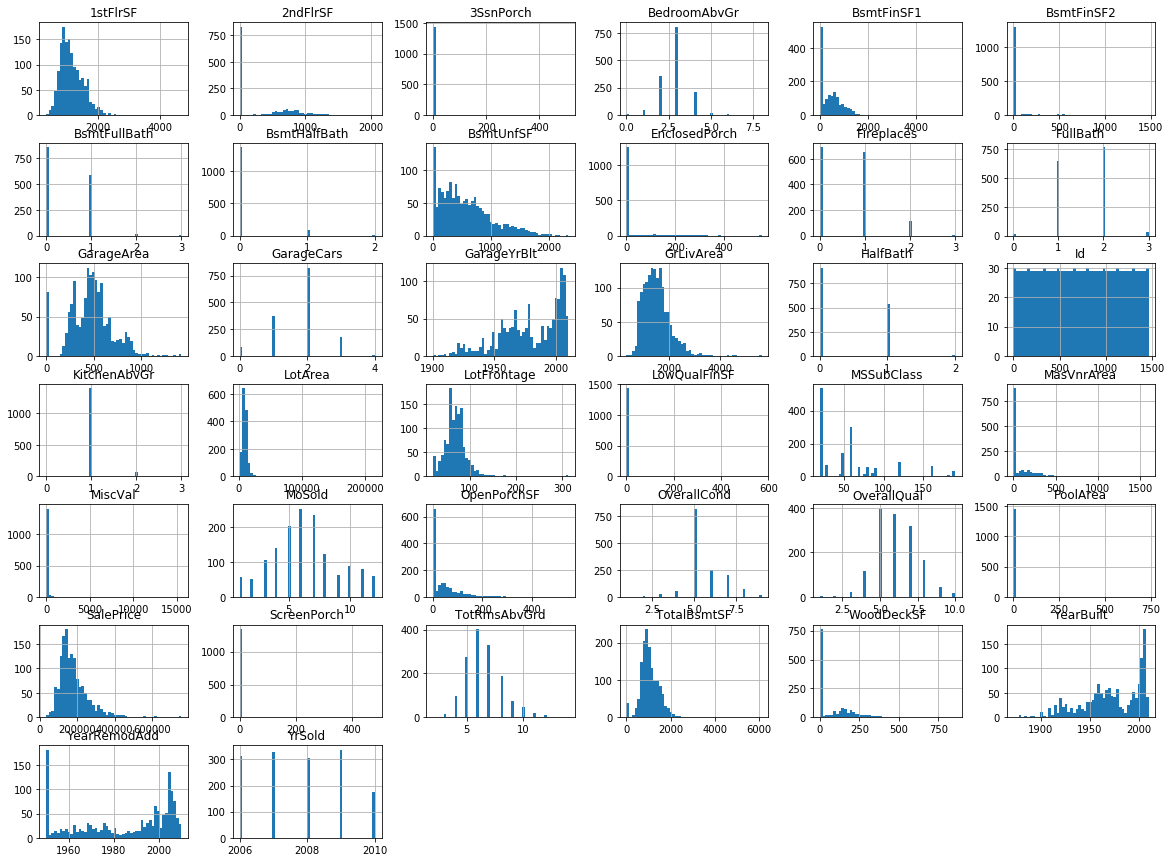

In [5]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

All the information I want to get from these plots are about odd distributions, not only I see there is a skew in some continuous variables, but also that some features have mostly one value.

One way to remove the skeweness is to simply take the logarithm of the variable. This is what we are going to do now with the target variable

In [6]:
df_train['target'] = np.log1p(df_train.SalePrice)
del df_train['SalePrice']

We will implement a cleaning procedure that follows the documentation shortly but, before even creating the evaluation environment, we want to remove 2 outliers that the documentation recommends to remove. See this step as following the instructions that came with the data.

In [7]:
df_train = df_train[df_train.GrLivArea < 4500].reset_index(drop=True)

Now, since we want to evaluate our model in order to be able to say how good or bad it can be in certain situations, we need to create our test set (not the test set provided by kaggle, that one will arrive in a month after we are done). Every insight and every decision will come from something we will do on the train set, leaving the evaluation of our choices as pure as possible.

If we were doing the data exploration phase before this step, we would have used information coming from both sets to take decisions, a luxury that in a realistic situation we won't have.

How to split the data? Giving the size of the training set, it makes sense to use a 80-20 split. A random split will do the job just fine but we can also use some knowledge of the problem. Since all that matters for a house is *location, location, location* , we can make the split in order to correctly represent the distribution of the houses across the various Neighborhoods (i.e. we can *stratify* the split).

In [8]:
def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set

In [9]:
train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

And we see that the proportion of houses per Neighborhood is approximatively preserved

In [10]:
train_set.Neighborhood.value_counts(normalize=True)

NAmes      0.154374
CollgCr    0.102916
OldTown    0.077187
Edwards    0.066895
Somerst    0.059177
Gilbert    0.054031
NridgHt    0.053173
Sawyer     0.050600
NWAmes     0.049743
SawyerW    0.040309
BrkSide    0.039451
Crawfor    0.035163
Mitchel    0.033448
NoRidge    0.028302
IDOTRR     0.025729
Timber     0.025729
ClearCr    0.018868
StoneBr    0.017153
SWISU      0.017153
MeadowV    0.012007
Blmngtn    0.012007
BrDale     0.011149
Veenker    0.007719
NPkVill    0.006003
Blueste    0.001715
Name: Neighborhood, dtype: float64

In [11]:
df_train.Neighborhood.value_counts(normalize=True)

NAmes      0.154321
CollgCr    0.102881
OldTown    0.077503
Edwards    0.067215
Somerst    0.058985
Gilbert    0.054184
NridgHt    0.052812
Sawyer     0.050754
NWAmes     0.050069
SawyerW    0.040466
BrkSide    0.039781
Crawfor    0.034979
Mitchel    0.033608
NoRidge    0.028121
Timber     0.026063
IDOTRR     0.025377
ClearCr    0.019204
SWISU      0.017147
StoneBr    0.017147
Blmngtn    0.011660
MeadowV    0.011660
BrDale     0.010974
Veenker    0.007545
NPkVill    0.006173
Blueste    0.001372
Name: Neighborhood, dtype: float64

Before getting insights from the data, let's take the final step of the instructions that came with the data (i.e. the data description) and have a general cleaning

In [12]:
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline
    '''
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = X['YearBuilt']  # if no garage, use the age of the building
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        del X['Id']
        del X['MiscFeature']  # we already know it doesn't matter
        
        return X

Why a class? Because we want to be able to reproduce every step on unseen data and a class makes easier to have a very clear set of steps to follow. More explanation on this and on the use of Pipelines (that will come later) can be found in this other notebook https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline

To use this class and clean our data, we can simply do

In [13]:
train_cleaned = train_set.copy()  # I want to work on train_set again later from scratch

train_cleaned = general_cleaner().fit_transform(train_cleaned)

mis_cols = exp.list_missing(train_cleaned)

Column MasVnrType: 0.69% missing
Column MasVnrArea: 0.69% missing
Column BsmtFinType2: 0.09% missing
Column Electrical: 0.09% missing


We see that most of the missing values were actually very well explained by the documentation, we will deal with the remaining ones later on.

Please note that we don't know what is going to be missing in the future, thus, even if there were no missing values remaining in our data, we should implement procedures to clean the data anyway (or, in alternative, throw appropriate errors so that the team maintaing the model will know quickly what to do).

# Get insights from the data

This phase is tricky because it is easy to go too deep into the rabbit hole. We want to have a comprehensive understanding of the data but at the same time we don't want to spend too much time on it. While in this dataset the number of features is fairly limited, in other cases a slow approach can cost us weeks of work and, at this stage, we don't know if this work is worth weeks of our time.

We will thus focus on the following:

* Correlation with the target
* Univariate and bivariate analysis of the interesting features
* Interesting segmentations with categorical features

Once again, please note how we don't use the full training set but only what we have created in the previous section.

## Numerical features

To first identify what can be interesting, we can look the correlations with the target. This is not by any means enough or necessary to make a feature interesting but, in absence of other knowledge, it is a good first step.

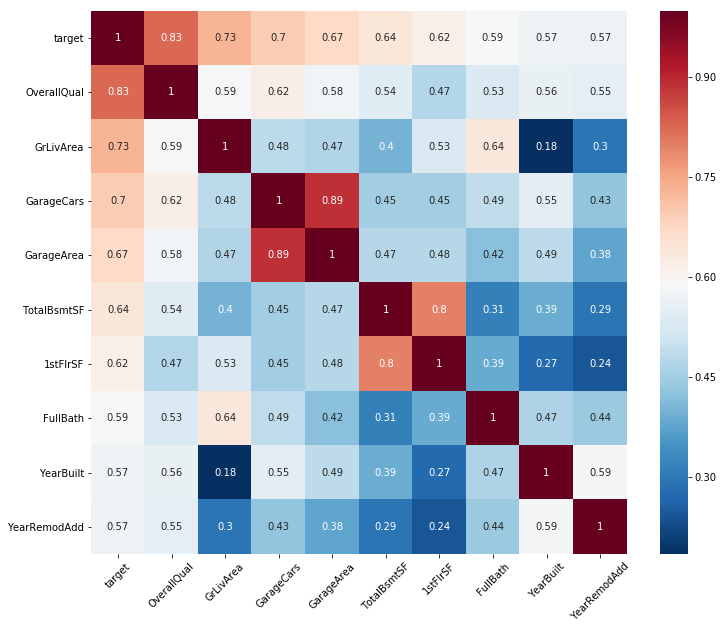

In [14]:
high_corr = exp.plot_correlations(train_cleaned, 'target', limit=10, annot=True)

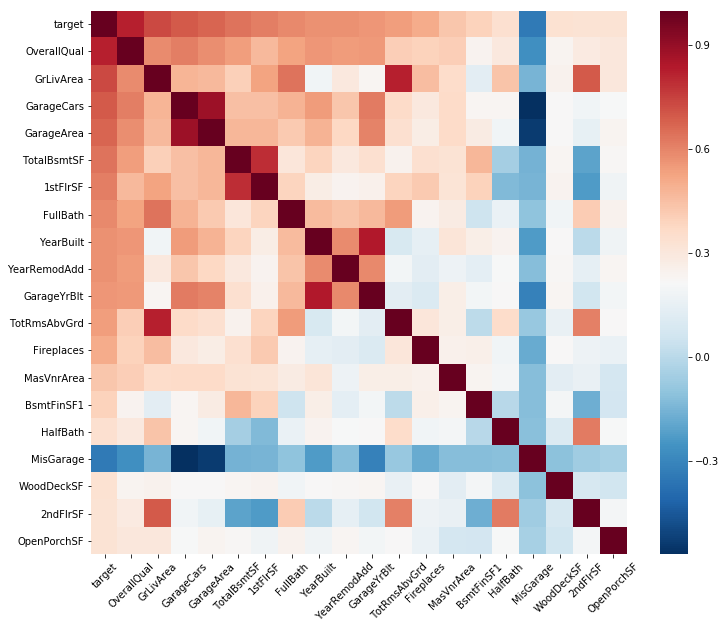

In [15]:
high_corr = exp.plot_correlations(train_cleaned, 'target', limit=20)

Nothing particularly shocking here:

* Overall quality and price are very correlated
* GarageCars and GarageArea are very correlated
* Other fairly expected things

Let's have a look at some distributions, starting with the target variable.

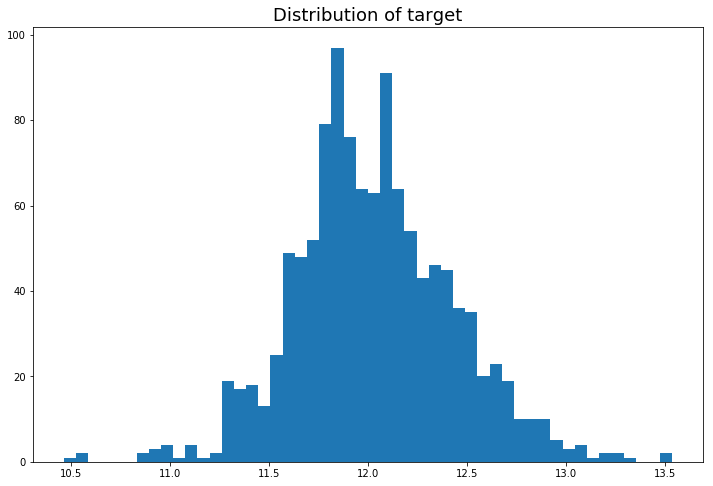

In [16]:
exp.plot_distribution(train_cleaned, 'target')

Yes, we removed the skewness with that logarithm transformation in the previous section.

Let's continue by looking at the numerical features most correlated with the target.

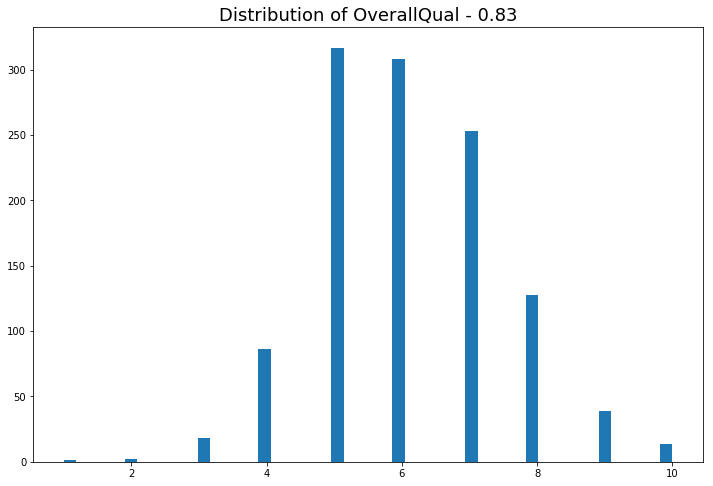

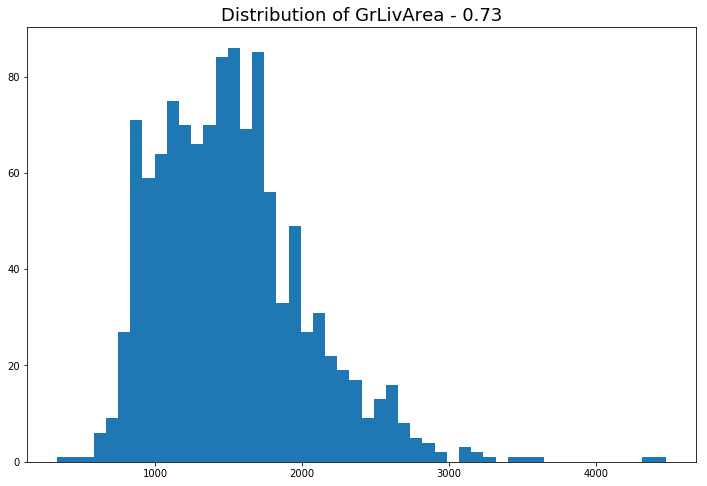

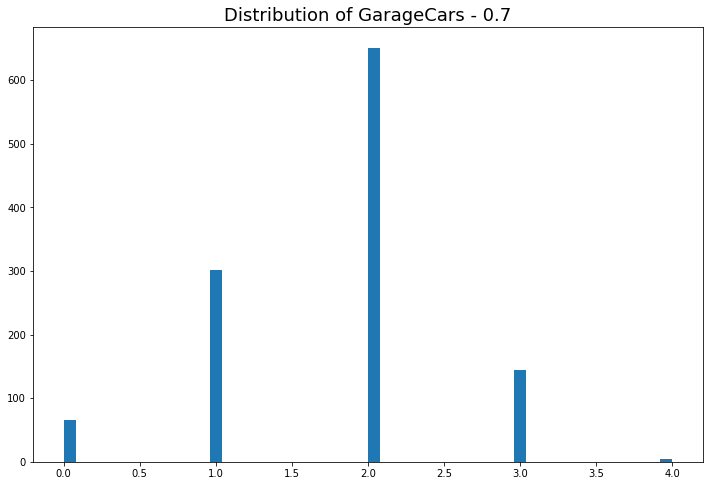

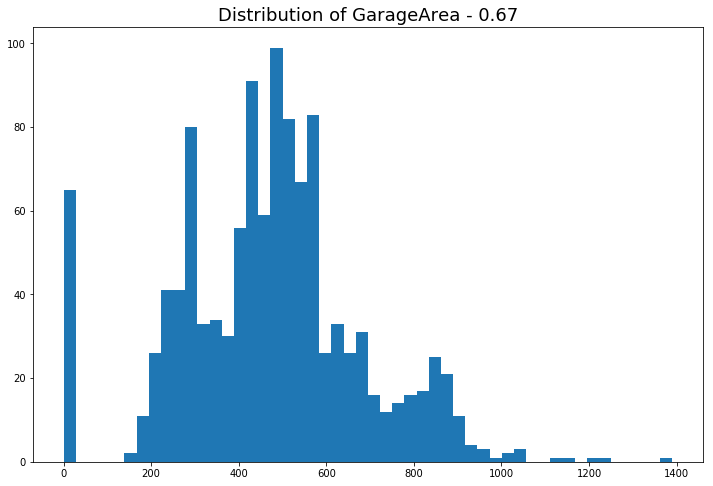

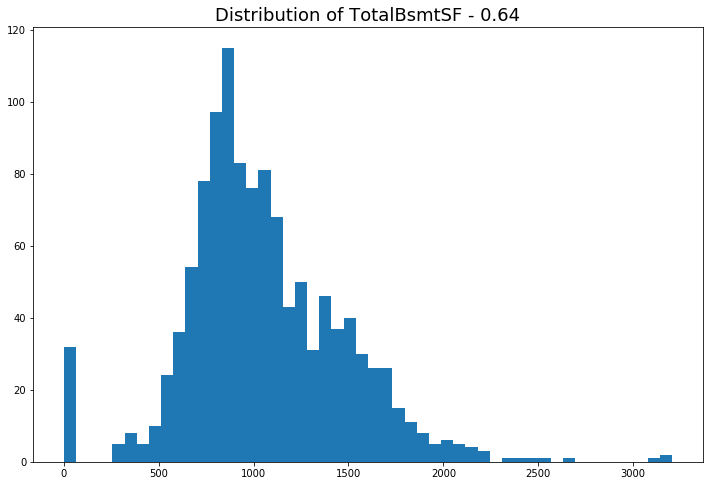

In [17]:
for col in high_corr[1:6].index:
    exp.plot_distribution(train_cleaned, col, correlation=high_corr)

We see, for example, that the negative skew is also present in GrLivArea, a feature that we all expect playing a big role in determining the final price. 

Let's try to get more insights with a bivariate analysis

              OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
OverallQual      1.000000   0.587055    0.618582    0.577956     0.541684   
GrLivArea        0.587055   1.000000    0.482516    0.471170     0.399067   
GarageCars       0.618582   0.482516    1.000000    0.889179     0.449308   
GarageArea       0.577956   0.471170    0.889179    1.000000     0.474743   
TotalBsmtSF      0.541684   0.399067    0.449308    0.474743     1.000000   
1stFlrSF         0.471802   0.530118    0.450187    0.476417     0.796268   
FullBath         0.531866   0.638428    0.488032    0.423072     0.311910   
YearBuilt        0.562561   0.184469    0.548583    0.486097     0.389798   
YearRemodAdd     0.551677   0.295764    0.431481    0.378194     0.294774   
GarageYrBlt      0.555664   0.230821    0.620629    0.607188     0.339224   
TotRmsAbvGrd     0.410755   0.824105    0.367417    0.339575     0.250345   
target           0.826131   0.730448    0.696102    0.673793     0.641253   

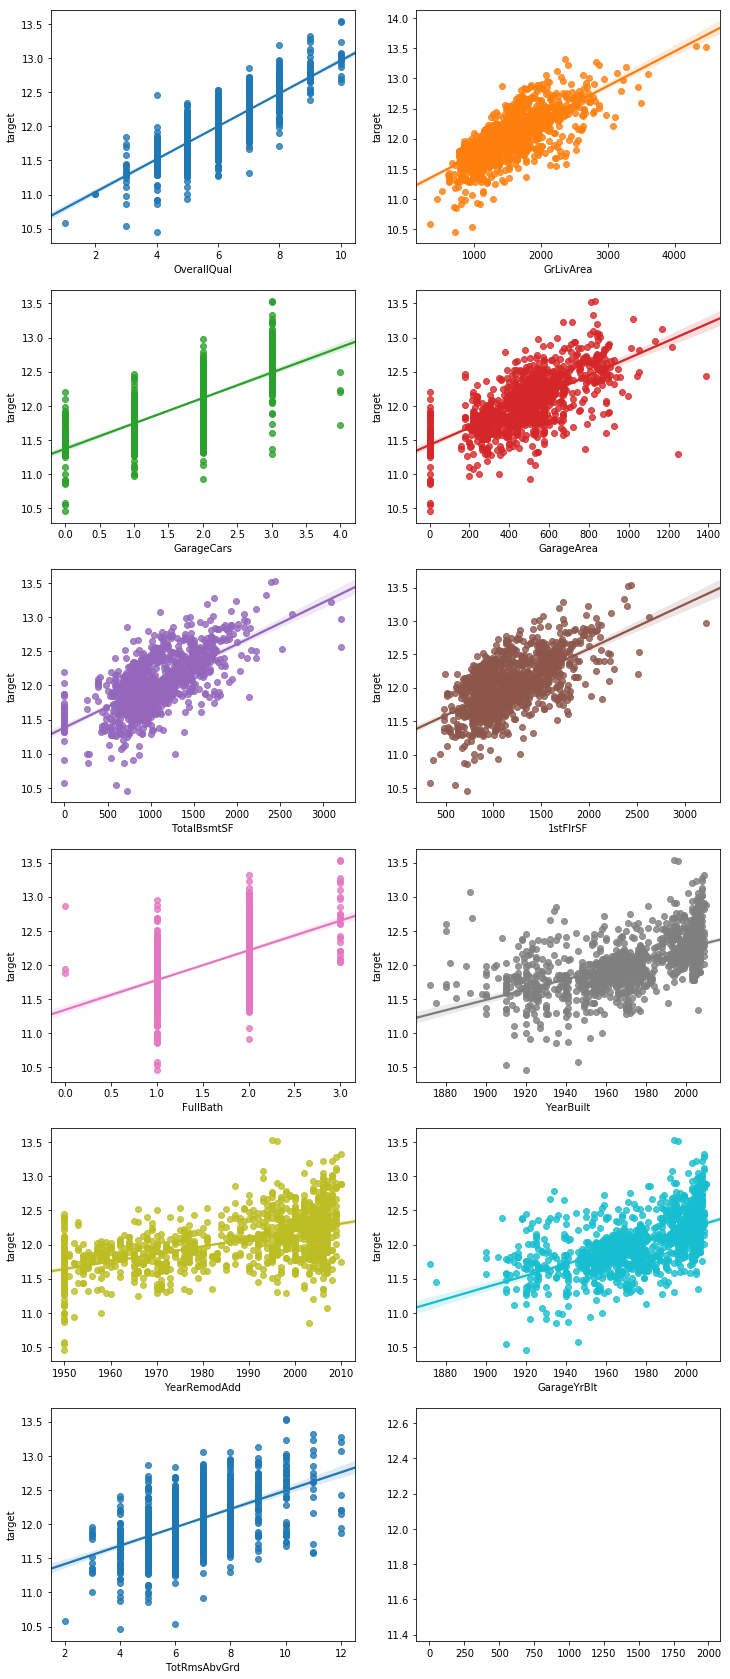

In [18]:
exp.corr_target(train_cleaned, 'target', list(high_corr[1:12].index))

The discrete values of GarageCars and OverallQual invite in using some estimator to see if the patter is clear as it looks.

             OverallQual  GarageCars    target
OverallQual     1.000000    0.618582  0.826131
GarageCars      0.618582    1.000000  0.696102
target          0.826131    0.696102  1.000000


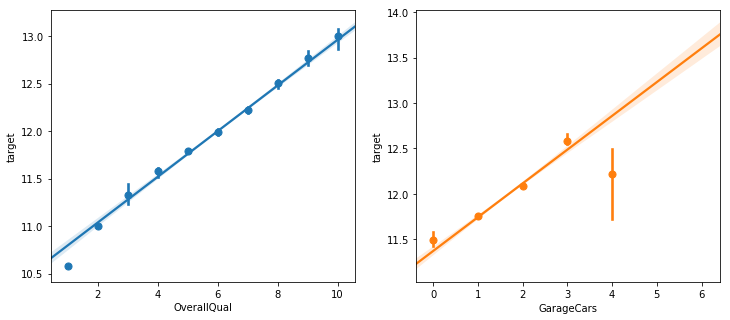

In [19]:
exp.corr_target(train_cleaned, 'target',
                [col for col in high_corr.index if 'Qual' in col or 'Car' in col],
                x_estimator=np.median)

Yes, it is very clear indeed. Let's move on to the categorical features.

## Categorical features

In this dataset we don't have many features and, thanks to the function in the `explore_data` utility script, we can quickly shuffle through all of them to find the interesting one. If this was not possible, one approach would be to find the features whose cateogories exhibit a significantly different distribution of the target variable. In other words, for example, if the distribution of prices for houses withouth a Fence is significantly different than the ones with a Fence, the next function will catch it and tell us.

In [20]:
exp.find_cats(train_cleaned, 'target', thrs=0.3, critical=0.05)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4862: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / n2
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


['LotShape',
 'HouseStyle',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'KitchenQual']

We can start from these to see if we get some insight

count       mean        max        min     median       std
BsmtQual                                                             
Ex           92  12.661743  13.534474  11.724005  12.683831  0.343460
Fa           22  11.726709  12.239996  11.198228  11.734057  0.262231
Gd          496  12.184570  13.195616  11.289794  12.178193  0.284848
NoBsmt       32  11.532958  12.198549  10.579005  11.552167  0.301022
TA          524  11.807075  13.071072  10.460271  11.813037  0.300840

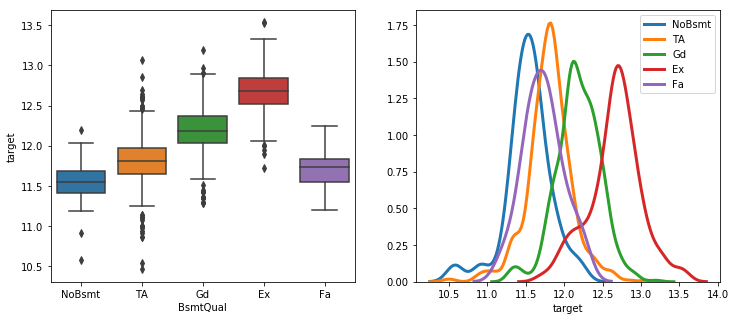

In [21]:
exp.segm_target(train_cleaned, 'BsmtQual', 'target')

It seems there is a very clear relation between the quality of the basement and the sale price. Moreover, it invites in recoding `BsmtQual` into an ordinal feature.

The same holds for `KitchenQual`

count       mean        max        min     median       std
KitchenQual                                                             
Ex              81  12.675378  13.534474  11.429555  12.691584  0.376239
Fa              31  11.465739  12.069686  10.579005  11.594515  0.371069
Gd             463  12.224121  12.991756  11.277216  12.225880  0.282112
TA             591  11.811277  12.791359  10.460271  11.820418  0.277610

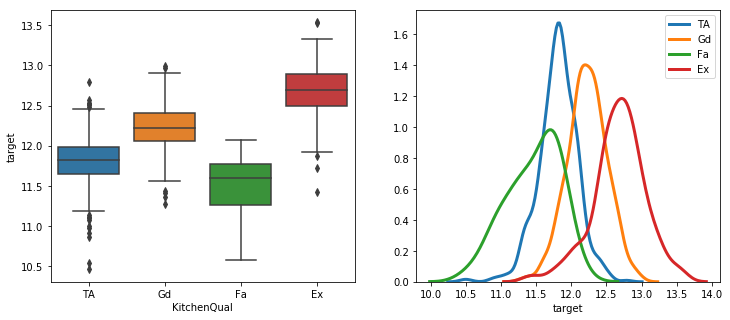

In [22]:
exp.segm_target(train_cleaned, 'KitchenQual', 'target')

Or of `ExterQual`

count       mean        max        min     median       std
ExterQual                                                             
Ex            41  12.804920  13.534474  12.081082  12.823631  0.319093
Fa            11  11.220981  11.711785  10.579005  11.314487  0.329191
Gd           391  12.310935  13.521141  10.859018  12.314932  0.288026
TA           723  11.840067  12.850557  10.460271  11.845110  0.290072

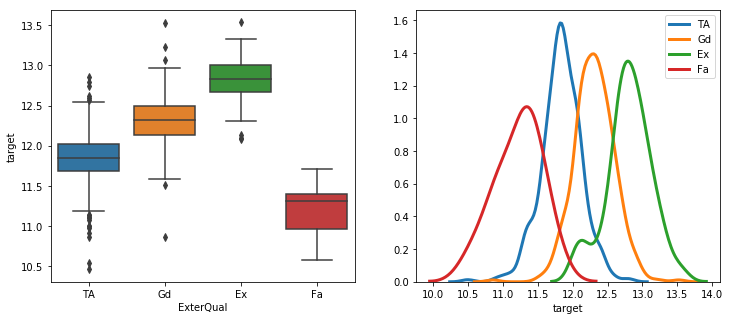

In [23]:
exp.segm_target(train_cleaned, 'ExterQual', 'target')

count       mean        max        min     median       std
LotShape                                                             
IR1         370  12.185910  13.534474  10.859018  12.157409  0.373096
IR2          35  12.333127  13.195616  11.884496  12.310437  0.344046
IR3           7  12.136881  12.523530  11.198228  12.165985  0.462872
Reg         754  11.932324  13.275829  10.460271  11.884496  0.383705

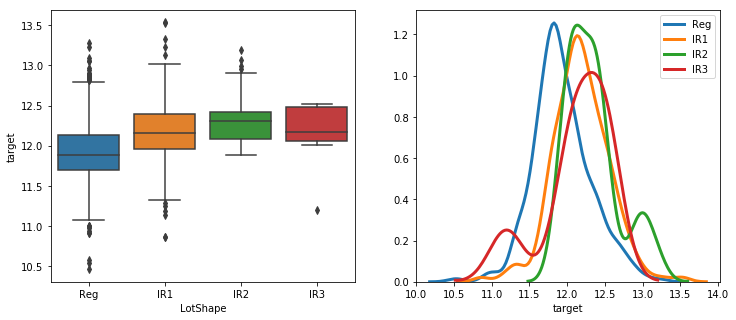

In [24]:
exp.segm_target(train_cleaned, 'LotShape', 'target')

Here it looks it makes a difference only in having a regular vs irregular lot shape.

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


count       mean        max        min     median       std
MasVnrType                                                             
BrkCmn         11  11.885626  12.531776  11.607335  11.842236  0.263243
BrkFace       352  12.173350  13.534474  11.320566  12.125406  0.347471
None          697  11.893713  13.521141  10.460271  11.867104  0.364996
Stone          98  12.429558  13.323929  11.686887  12.425865  0.377575

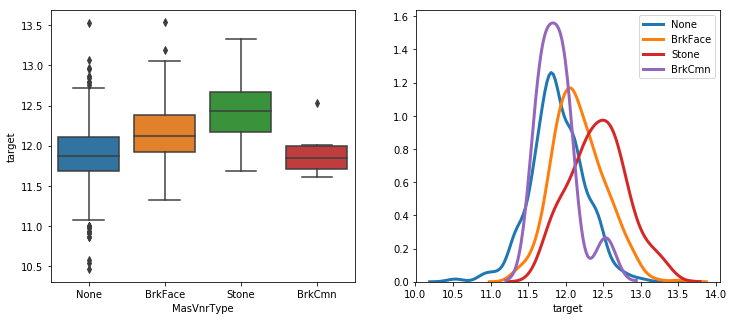

In [25]:
exp.segm_target(train_cleaned, 'MasVnrType', 'target')

The other features found above do not show anything in particular on this kind of plots, so we won't display them. We can have a quick look at other features not found by that function, for example

count       mean        max        min     median       std
CentralAir                                                             
N              80  11.506346  12.491176  10.460271  11.502834  0.381048
Y            1086  12.064336  13.534474  10.859018  12.043265  0.374701

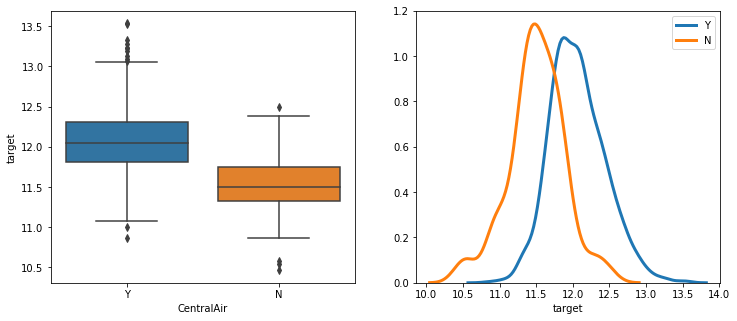

In [26]:
exp.segm_target(train_cleaned, 'CentralAir', 'target')

count       mean        max        min     median       std
GarageFinish                                                             
Fin             278  12.318569  13.534474  11.320566  12.286128  0.370954
NoGrg            65  11.468998  12.208575  10.460271  11.492733  0.351975
RFn             336  12.170259  13.275829  11.133143  12.154785  0.294461
Unf             487  11.833927  13.071072  10.933000  11.813037  0.297419

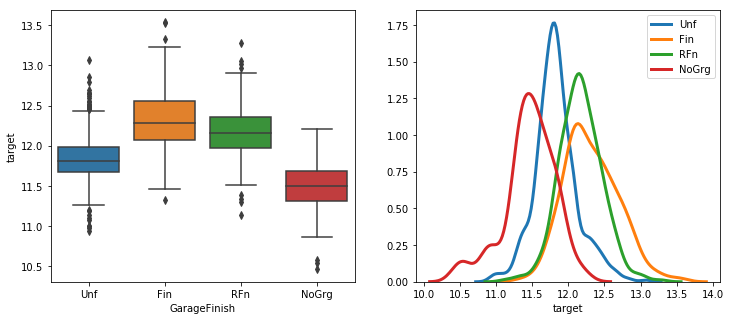

In [27]:
exp.segm_target(train_cleaned, 'GarageFinish', 'target')

Another way of looking at these features is to combine them in a plot together with another numerical feature. We know that `GrLivArea` is going to be important and our function told us that `HouseStyle` has interesting categories in it. We can combine them like this

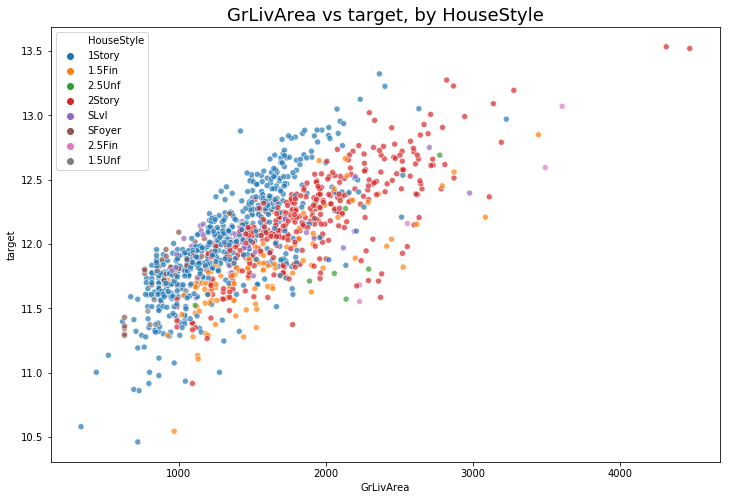

In [28]:
exp.plot_bivariate(train_cleaned, 'GrLivArea', 'target', hue='HouseStyle', alpha=0.7)

Or use this plot to just investigate further the features we have analyzed before

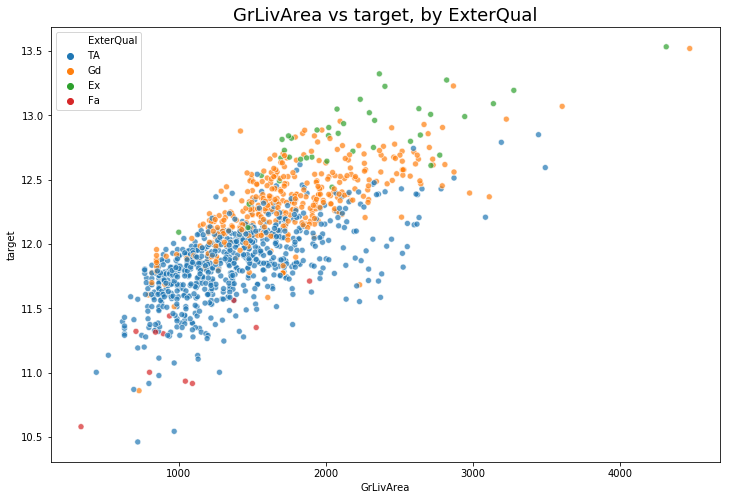

In [29]:
exp.plot_bivariate(train_cleaned, 'GrLivArea', 'target', hue='ExterQual', alpha=0.7)

As mentioned before, it is easy to go too deep in the rabbit hole in this phase. I have been writing this section for an hour already and I feel confident enough about the data to run the first models.

# First models, validation, and error analysis.

This section has multiple goals, the main one is to bridge to the next section about feature engineering. We want to implement a system of evaluating, selecting, and tuning our models that is robust enough to the data processing phase. If we do this part correctly, we will be able to quickly iterate between the processing and modeling phase, being confident that we can correctly assess the validity of our actions. 

As explained already in this notebook https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline, we need different transformations for numeric and categorical features. We will use the insights gained in the previous section to make a few new custom transformers.

In [30]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True, bedroom=True, bath=True, lot=True, service=True):
        self.columns = []  # useful to well behave with FeatureUnion
        

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
            X = self.remove_skew(X, col)

        self.columns = X.columns
        return X
    

    def get_feature_names(self):
        return self.columns
    
    
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and unsure_conversion
    '''
    def __init__(self, cols, extra_cols=None, include_extra=True):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra:
                self.cols += self.extra_cols
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X


class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase.
    '''
    def fit(self, X, y=None):
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                  'CarPort': 'Detchd', 
                                                  '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf',
                                                     '2.5Fin': '2Story',
                                                     '2.5Unf': '2Story',
                                                     'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        return X
    

class drop_columns(BaseEstimator, TransformerMixin):
    '''
    Drops columns that are not useful for the model
    '''
    def __init__(self):
        self.columns = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        to_drop = [col for col in X.columns if 'NoGrg' in col]  # dropping dummies that are redundant
        to_drop += [col for col in X.columns if 'NoBsmt' in col]
        # other not useful columns
        to_drop += [col for col in X.columns if 'MSSubClass' in col]
        to_drop += [col for col in X.columns if 'Neighborhood' in col]  # maybe useful in the future
        to_drop += [col for col in X.columns if 'Condition1' in col]
        to_drop += [col for col in X.columns if 'Condition2' in col]
        to_drop += [col for col in X.columns if 'ExterCond' in col]  # maybe make it ordinal
        to_drop += [col for col in X.columns if 'Exterior1st' in col]
        to_drop += [col for col in X.columns if 'Exterior2nd' in col]
        to_drop += [col for col in X.columns if 'Functional' in col]
        to_drop += [col for col in X.columns if 'Heating_' in col]  # we don't want to drop the dummies of HeatingQC too
        to_drop += [col for col in X.columns if 'PoolQC' in col]
        to_drop += [col for col in X.columns if 'RoofMatl' in col]
        to_drop += [col for col in X.columns if 'RoofStyle' in col]
        to_drop += [col for col in X.columns if 'SaleCondition' in col]
        to_drop += [col for col in X.columns if 'SaleType' in col]
        to_drop += [col for col in X.columns if 'Utilities' in col]
        to_drop += [col for col in X.columns if 'BsmtCond' in col]  # maybe ordinal
        to_drop += [col for col in X.columns if 'Electrical' in col]
        to_drop += [col for col in X.columns if 'Foundation' in col]
        to_drop += [col for col in X.columns if 'LandSlope' in col]
        to_drop += [col for col in X.columns if 'Street' in col]
        to_drop += [col for col in X.columns if 'Fence' in col]
        to_drop += [col for col in X.columns if 'PavedDrive' in col]

        for col in to_drop:
            try:
                del X[col]
            except KeyError:
                pass
            
        self.columns = X.columns
        return X
    
    def get_feature_names(self):
        return list(self.columns)

In [31]:
numeric_pipe = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imputer', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imputer', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify())])


processing_pipe = dfp.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('gen_cl', general_cleaner()), 
                      ('processing', processing_pipe), 
                      ('scaler', dfp.df_scaler()), 
                      ('dropper', drop_columns())])

tmp = train_set.copy()

full_pipe.fit_transform(tmp).head()

Alley  LotShape  LandContour  ExterQual  BsmtQual  HeatingQC  \
1231 -0.260318  0.739202     -0.24691  -0.691394 -3.956431  -1.195302   
1456 -0.260318  0.739202     -0.24691  -0.691394 -0.547664  -0.153656   
242  -0.260318  0.739202     -0.24691  -0.691394 -0.547664  -0.153656   
93   -0.260318  0.739202     -0.24691  -0.691394 -0.547664   0.887990   
1268 -0.260318  0.739202     -0.24691  -0.691394 -0.547664  -1.195302   

      KitchenQual  GarageQual  GarageCond  MSZoning_RL  MSZoning_RM  \
1231    -0.766243    0.256754    0.262237     0.523753    -0.523753   
1456     0.737864    0.256754    0.262237     0.523753    -0.523753   
242     -0.766243   -1.122854    0.262237    -1.909298     1.909298   
93      -0.766243    0.256754    0.262237    -1.909298     1.909298   
1268    -0.766243    0.256754    0.262237     0.523753    -0.523753   

      LotConfig_Corner  LotConfig_CulDSac  LotConfig_Inside  BldgType_1Fam  \
1231          1.954017          -0.265908         -1.629470      -2.245318   
1456         -0.511766          -0.265908          0.613696       0.445371   
242           1.954017          -0.265908         -1.629470       0.445371   
93            1.954017          -0.265908         -1.629470      -2.245318   
1268         -0.511766          -0.265908          0.613696       0.445371   

      BldgType_Duplex  BldgType_TwnhsE  HouseStyle_1.5Unf  HouseStyle_1Story  \
1231         4.018340        -0.346521          -0.358819           1.015558   
1456        -0.248859        -0.346521          -0.358819           1.015558   
242         -0.248859        -0.346521           2.786919          -0.984680   
93           4.018340        -0.346521          -0.358819          -0.984680   
1268        -0.248859        -0.346521           2.786919          -0.984680   

      HouseStyle_2Story  HouseStyle_SFoyer  MasVnrType_BrkFace  \
1231          -0.692600           -0.27323            -0.67235   
1456          -0.692600           -0.27323            -0.67235   
242           -0.692600           -0.27323            -0.67235   
93             1.443834           -0.27323            -0.67235   
1268          -0.692600           -0.27323             1.48732   

      MasVnrType_None  MasVnrType_Stone  BsmtExposure_Av  BsmtExposure_Gd  \
1231         0.808641          -0.30292        -0.411714        -0.312935   
1456         0.808641          -0.30292        -0.411714        -0.312935   
242          0.808641          -0.30292        -0.411714        -0.312935   
93           0.808641          -0.30292        -0.411714        -0.312935   
1268        -1.236642          -0.30292        -0.411714        -0.312935   

      BsmtExposure_Mn  BsmtExposure_No  BsmtFinType1_ALQ  BsmtFinType1_BLQ  \
1231        -0.271413        -1.424279         -0.408861         -0.335552   
1456         3.684427        -1.424279         -0.408861         -0.335552   
242         -0.271413         0.702109         -0.408861         -0.335552   
93           3.684427        -1.424279         -0.408861         -0.335552   
1268        -0.271413         0.702109         -0.408861          2.980160   

      BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_Rec  BsmtFinType1_Unf  \
1231         -0.622973         -0.230862         -0.322749         -0.660273   
1456          1.605206         -0.230862         -0.322749         -0.660273   
242          -0.622973         -0.230862         -0.322749          1.514525   
93           -0.622973         -0.230862          3.098387         -0.660273   
1268         -0.622973         -0.230862         -0.322749         -0.660273   

      BsmtFinType2_ALQ  BsmtFinType2_BLQ  BsmtFinType2_GLQ  BsmtFinType2_LwQ  \
1231         -0.117954          -0.15102         -0.093008         -0.186025   
1456         -0.117954          -0.15102         -0.093008         -0.186025   
242          -0.117954          -0.15102         -0.093008         -0.186025   
93           -0.117954          -0.15102         -0.093008     

As you can see, we fill the missing values either with the median or with the mode, we remove the skew from some numerical features, we make some categorical feature ordinal, and we recode some categories accordingly to what we have already seen in the data exploration phase. By also using those insights, we drop some columns to make our model simpler. A few of these columns might be useful later on but for now we can safely drop them.

At the end of this pipeline, we will put a model. We know we need a regressor, but we still don't know what model is going to be good enough for us. We thus need to implement some methods to evaluate the models. At that point, we can simply try some models and focus on the most promising one.

There is no point now to play around with hyperparameters as we still have to try to improve the quality of our data before, which will improve our model far more than a fine tuned parameter

In [32]:
def cv_score(df_train, y_train, kfolds, pipeline, imp_coef=False):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    feat_df = pd.DataFrame()
    
    for n_fold, (train_index, test_index) in enumerate(kfolds.split(train.values)):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()

        if imp_coef:
            try:
                fold_df = get_coef(pipeline)
            except AttributeError:
                fold_df = get_feature_importance(pipeline)
                
            fold_df['fold'] = n_fold + 1
            feat_df = pd.concat([feat_df, fold_df], axis=0)
       
    if imp_coef:
        feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
        feat_df['abs_sco'] = (abs(feat_df['mean']))
        feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
        del feat_df['abs_sco']
        return oof, feat_df
    else:    
        return oof


def grid_search(data, target, estimator, param_grid, scoring, cv, random=False):
    
    if random:
        grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, cv=cv, scoring=scoring, 
                                  n_iter=random, n_jobs=-1, random_state=434, iid=False)
    else:
        grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    
    pd.options.mode.chained_assignment = None  # turn on and off a warning of pandas
    tmp = data.copy()
    grid = grid.fit(tmp, target)
    pd.options.mode.chained_assignment = 'warn'
    
    result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False).reset_index()
    
    del result['params']
    times = [col for col in result.columns if col.endswith('_time')]
    params = [col for col in result.columns if col.startswith('param_')]
    
    result = result[params + ['mean_test_score', 'std_test_score'] + times]
    
    return result, grid.best_params_, grid.best_estimator_


def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result['abs_res'] = abs(result['score'])
    result = result.sort_values(by=['abs_res'],ascending=False)
    del result['abs_res']
    return result


def get_feature_importance(pipe):
    imp = pipe.steps[-1][1].feature_importances_.tolist() #it's a pipeline
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')

In [33]:
models = [('lasso', Lasso(alpha=0.01)), ('ridge', Ridge()), ('sgd', SGDRegressor()), 
          ('forest', RandomForestRegressor(n_estimators=200)), ('xtree', ExtraTreesRegressor(n_estimators=200)), 
          ('svr', SVR()), 
          ('kneig', KNeighborsRegressor()),
          ('xgb', xgb.XGBRegressor(n_estimators=200, objective='reg:squarederror')), 
          ('lgb', lgb.LGBMRegressor(n_estimators=200))]

mod_name = []
rmse_train = []
rmse_test = []
mae_train = []
mae_test = []

folds = KFold(5, shuffle=True, random_state=541)

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target']
del test_set['target']

warnings.filterwarnings("ignore", 
                        message="The dummies in this set do not match the ones in the train set, we corrected the issue.")

for model in models:
    
    train = train_set.copy()
    test = test_set.copy()
    print(model[0])
    mod_name.append(model[0])
    
    pipe = [('gen_cl', general_cleaner()),
            ('processing', processing_pipe),
            ('scl', dfp.df_scaler()),
            ('dropper', drop_columns())] + [model]
    
    model_pipe = Pipeline(pipe)
            
    inf_preds = cv_score(train, y, folds, model_pipe)
    
    model_pipe.fit(train, y)  # refit on full train set
    
    preds = model_pipe.predict(test)
    
    rmse_train.append(mean_squared_error(y, inf_preds))
    rmse_test.append(mean_squared_error(y_test, preds))
    mae_train.append(mean_absolute_error(np.expm1(y), np.expm1(inf_preds)))
    mae_test.append(mean_absolute_error(np.expm1(y_test), np.expm1(preds)))
    
    print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, inf_preds)), 4)}')
    print(f'\tTrain set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(inf_preds)), 2)}')
    print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
    print(f'\tTest set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
    
    print('_'*40)
    print('\n')
    
results = pd.DataFrame({'model_name': mod_name, 
                        'rmse_train': rmse_train, 'rmse_test': rmse_test,
                        'mae_train': mae_train, 'mae_test': mae_test})

results

lasso
	Train set RMSE: 0.1227
	Train set MAE: 15672.49
	Test set RMSE: 0.1362
	Test set MAE: 16698.57
________________________________________


ridge
	Train set RMSE: 0.122
	Train set MAE: 15277.38
	Test set RMSE: 0.1305
	Test set MAE: 15349.28
________________________________________


sgd
	Train set RMSE: 0.1275
	Train set MAE: 16616.7
	Test set RMSE: 0.1359
	Test set MAE: 16518.77
________________________________________


forest
	Train set RMSE: 0.1408
	Train set MAE: 17858.99
	Test set RMSE: 0.1528
	Test set MAE: 17943.62
________________________________________


xtree
	Train set RMSE: 0.1381
	Train set MAE: 17510.84
	Test set RMSE: 0.1551
	Test set MAE: 17771.92
________________________________________


svr
	Train set RMSE: 0.1615
	Train set MAE: 19630.64
	Test set RMSE: 0.1584
	Test set MAE: 18545.01
________________________________________


kneig
	Train set RMSE: 0.1882
	Train set MAE: 25021.49
	Test set RMSE: 0.1847
	Test set MAE: 22650.38
_________________________________

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


	Train set RMSE: 0.1274
	Train set MAE: 16189.24
	Test set RMSE: 0.1345
	Test set MAE: 15644.94
________________________________________


lgb
	Train set RMSE: 0.1323
	Train set MAE: 16829.13
	Test set RMSE: 0.1458
	Test set MAE: 17046.29
________________________________________




model_name  rmse_train  rmse_test     mae_train      mae_test
0      lasso    0.015047   0.018563  15672.486562  16698.572470
1      ridge    0.014880   0.017026  15277.383858  15349.278567
2        sgd    0.016267   0.018462  16616.703068  16518.770426
3     forest    0.019815   0.023333  17858.987090  17943.617852
4      xtree    0.019073   0.024052  17510.835576  17771.916937
5        svr    0.026070   0.025080  19630.642742  18545.007889
6      kneig    0.035407   0.034122  25021.486467  22650.376827
7        xgb    0.016237   0.018083  16189.237392  15644.938851
8        lgb    0.017491   0.021254  16829.131771  17046.290840

We will continue with the top5: Lasso, RandomForest, XGBoost, LGBoost, Ridge. We will have these results as baseline, being them the one we obtained by simply looking at the data.

We can investigate each of these models by looking at their predictions and at how those predictions are made. For example

In [34]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('processing', processing_pipe),
                       ('scl', dfp.df_scaler()), 
                       ('dropper', drop_columns()), 
                       ('lasso', Lasso(alpha=0.01))])

lasso_oof, lasso_coef = cv_score(train_set, y, folds, lasso_pipe, imp_coef=True)

lasso_coef

mean       std
feat                                 
GrLivArea          0.119406  0.005415
OverallQual        0.096697  0.002756
YearBuilt          0.040580  0.001912
LotArea            0.035916  0.002143
TotalBsmtSF        0.033952  0.002875
...                     ...       ...
HouseStyle_1Story  0.000000  0.000000
HouseStyle_2Story  0.000000  0.000000
HouseStyle_SFoyer  0.000000  0.000000
BsmtFinType1_Rec   0.000000  0.000000
BsmtFinType1_LwQ   0.000000  0.000000

[91 rows x 2 columns]

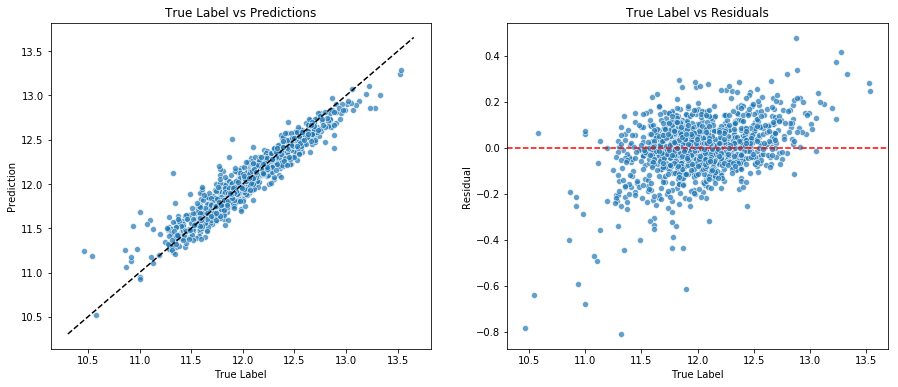

In [35]:
plot_predictions(train_set, y, lasso_oof)

This residual plot is fairly problematic and we will address it later on. 

We also notice that quite a few features do not matter for our predictions

In [36]:
lasso_coef[lasso_coef['mean']==0].sample(10)

mean  std
feat                         
LowQualFinSF         0.0  0.0
BsmtFinSF2           0.0  0.0
BsmtFinType1_Rec     0.0  0.0
Alley                0.0  0.0
BsmtFinType1_LwQ     0.0  0.0
MasVnrType_BrkFace   0.0  0.0
BsmtFinType2_GLQ     0.0  0.0
GarageType_Attchd    0.0  0.0
LotConfig_Corner     0.0  0.0
BedroomAbvGr         0.0  0.0

# Feature engineering and Feature selection

We have already implemented a few transformations for our base models. For example, we have already removed the skew from some numerical features and we can see that the result is promising

           GrLivArea  1stFlrSF   LotArea    target
GrLivArea   1.000000  0.532700  0.375878  0.741597
1stFlrSF    0.532700  1.000000  0.455827  0.611572
LotArea     0.375878  0.455827  1.000000  0.407437
target      0.741597  0.611572  0.407437  1.000000


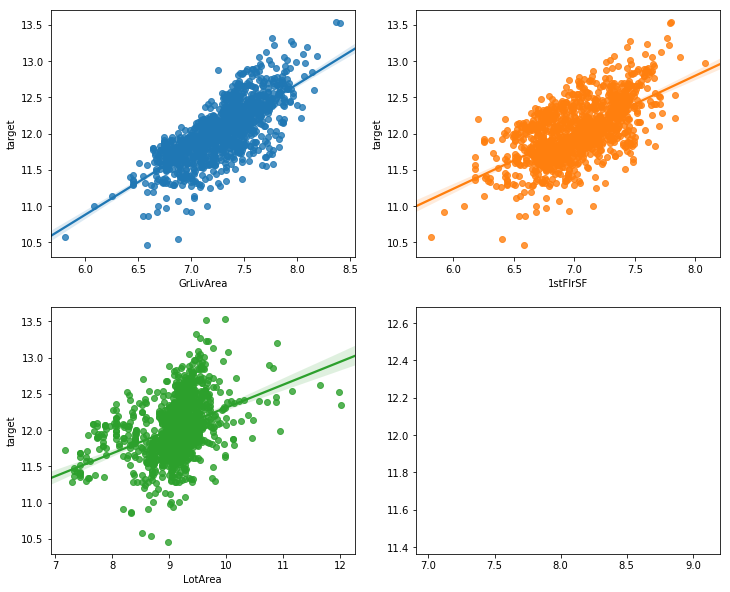

In [37]:
for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
    train_cleaned[col] = np.log1p(train_cleaned[col])

exp.corr_target(train_cleaned, 'target', ['GrLivArea', '1stFlrSF', 'LotArea'])

Moreover, we have already transformed some categorical features into ordinal ones

             BsmtQual  KitchenQual  GarageQual  GarageCond  ExterQual  \
BsmtQual     1.000000     0.511100    0.171536    0.188111   0.554887   
KitchenQual  0.511100     1.000000    0.232329    0.224139   0.714989   
GarageQual   0.171536     0.232329    1.000000    0.955815   0.214681   
GarageCond   0.188111     0.224139    0.955815    1.000000   0.210297   
ExterQual    0.554887     0.714989    0.214681    0.210297   1.000000   
HeatingQC    0.403084     0.499017    0.176256    0.181200   0.520420   
target       0.607152     0.690173    0.372389    0.365264   0.688002   

             HeatingQC    target  
BsmtQual      0.403084  0.607152  
KitchenQual   0.499017  0.690173  
GarageQual    0.176256  0.372389  
GarageCond    0.181200  0.365264  
ExterQual     0.520420  0.688002  
HeatingQC     1.000000  0.483002  
target        0.483002  1.000000  


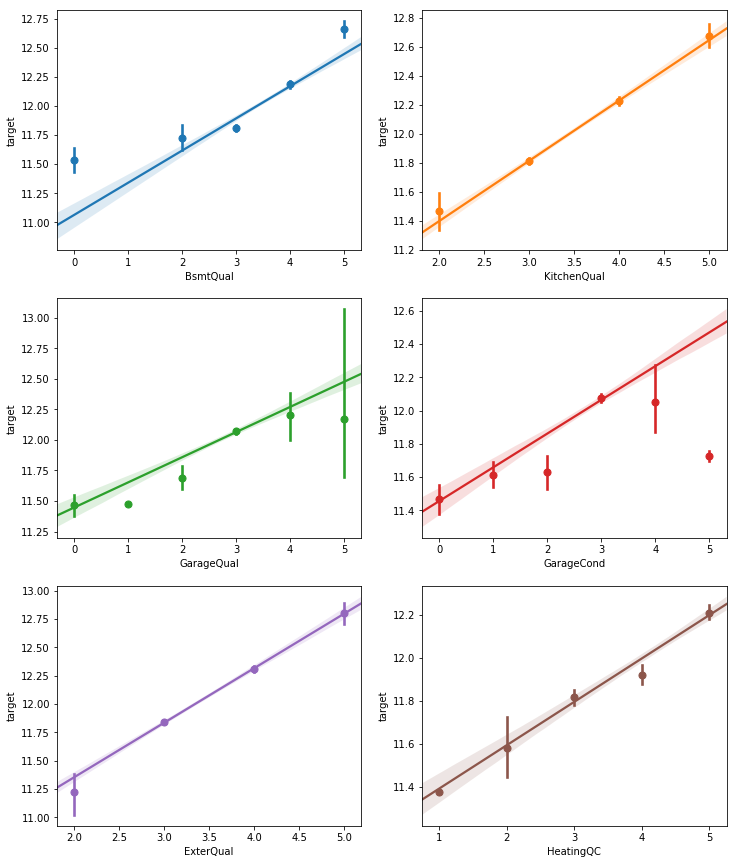

In [38]:
train_cleaned = make_ordinal(['BsmtQual', 'KitchenQual',
                              'GarageQual','GarageCond', 
                              'ExterQual', 'HeatingQC']).fit_transform(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['BsmtQual', 'KitchenQual',
                                          'GarageQual','GarageCond',
                                          'ExterQual', 'HeatingQC'], x_estimator=np.mean)

We indeed observe a linear relation between the target and some of these features. For others it will be probably be better to use a different encoding.

At last, at least regarding what we have already implemented, we recoded a few categories following common sense. The goal here is to not train on too rare categories as this can lead to poor generalizability of the model. We report here only one of those transformations as an example

count       mean        max        min     median       std
GarageType                                                             
Attchd        705  12.154445  13.534474  10.933000  12.119975  0.340577
BuiltIn        76  12.381833  13.275829  11.418626  12.334850  0.393289
Detchd        320  11.771839  13.071072  10.976799  11.763692  0.272710
NoGrg          65  11.468998  12.208575  10.460271  11.492733  0.351975

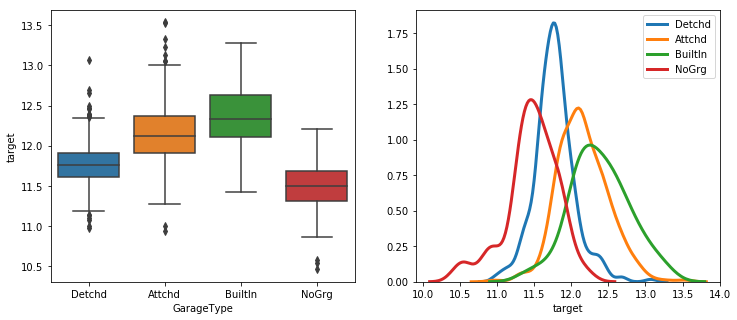

In [39]:
train_cleaned = recode_cat().fit_transform(train_cleaned)

exp.segm_target(train_cleaned, 'GarageType', 'target')

As we can see, the differences among different categories are more clear. This will definitely help the models.


## New features and what suggested them

We will now use some insights gained during the data exploration phase to make better features.

We noticed a good correlation between TotRmsAbvGrd, GrLivArea, and BedroomAbvGr, which is nothing shocking. Let's see what an interaction between the two looks like.

              GrLivArea  TotRmsAbvGrd  BedroomAbvGr  sf_per_room  \
GrLivArea      1.000000      0.819665      0.543195    -0.726105   
TotRmsAbvGrd   0.819665      1.000000      0.677524    -0.927202   
BedroomAbvGr   0.543195      0.677524      1.000000    -0.672979   
sf_per_room   -0.726105     -0.927202     -0.672979     1.000000   
bedroom_prop  -0.217718     -0.229407      0.530716     0.164960   
target         0.741597      0.543633      0.210188    -0.465772   

              bedroom_prop    target  
GrLivArea        -0.217718  0.741597  
TotRmsAbvGrd     -0.229407  0.543633  
BedroomAbvGr      0.530716  0.210188  
sf_per_room       0.164960 -0.465772  
bedroom_prop      1.000000 -0.320894  
target           -0.320894  1.000000  


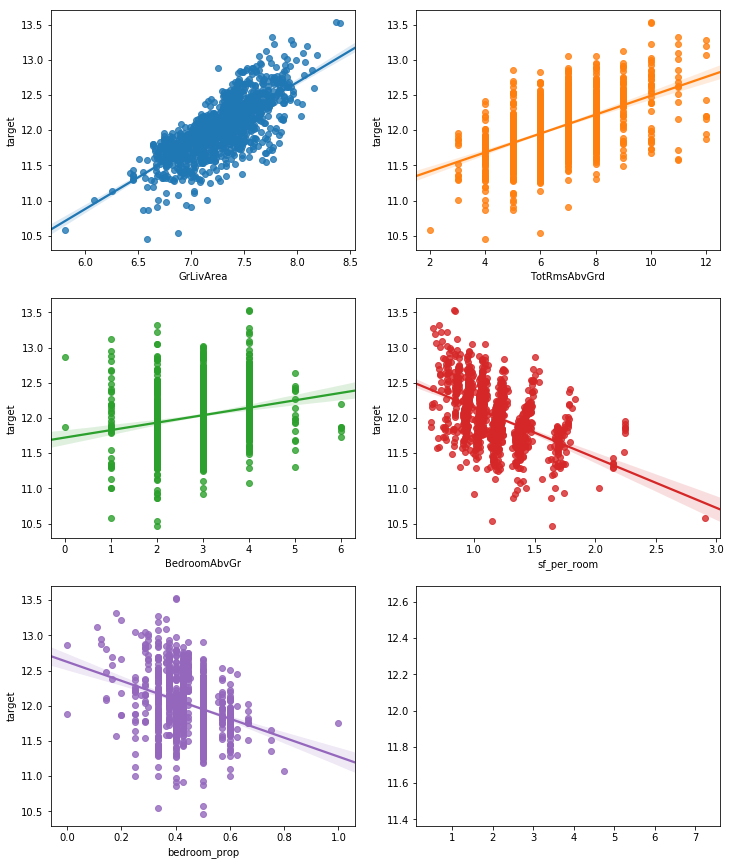

In [40]:
def SF_per_room(data):
    data['sf_per_room'] = data['GrLivArea'] / data['TotRmsAbvGrd']
    return data

def bedroom_prop(data):
    data['bedroom_prop'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']
    return data

train_cleaned = SF_per_room(train_cleaned)
train_cleaned = bedroom_prop(train_cleaned)

exp.corr_target(data=train_cleaned, 
                cols=['GrLivArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 'sf_per_room', 'bedroom_prop'], 
                target='target')

It looks we found something: the bigger the house, the more it costs, but the bigger the rooms (on average), the less the house is expensive.

Next, we have a lot of bath features that individually are not saying too much. Let's try to make something out of them.

              BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  total_bath  \
BsmtFullBath      1.000000     -0.149458 -0.053973 -0.031788    0.582381   
BsmtHalfBath     -0.149458      1.000000 -0.019015 -0.011742    0.031650   
FullBath         -0.053973     -0.019015  1.000000  0.162049    0.703567   
HalfBath         -0.031788     -0.011742  0.162049  1.000000    0.408878   
total_bath        0.582381      0.031650  0.703567  0.408878    1.000000   
target            0.246349      0.006646  0.589437  0.343117    0.677673   

                target  
BsmtFullBath  0.246349  
BsmtHalfBath  0.006646  
FullBath      0.589437  
HalfBath      0.343117  
total_bath    0.677673  
target        1.000000  


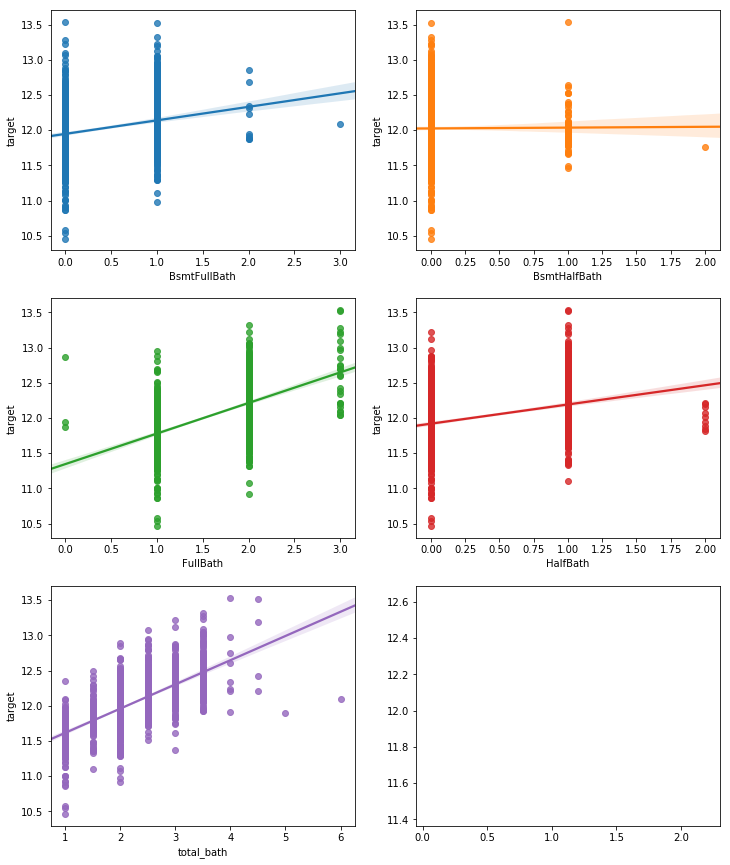

In [41]:
def total_bath(data):
    data['total_bath'] = data[[col for col in data.columns if 'FullBath' in col]].sum(axis=1) \
                        + 0.5 * data[[col for col in data.columns if 'HalfBath' in col]].sum(axis=1)
    return data

train_cleaned = total_bath(train_cleaned)
exp.corr_target(data=train_cleaned, 
                cols=[col for col in train_cleaned if 'Bath' in col] + ['total_bath'], 
                target='target')

This is indeed a clearer signal and we should consider using this feature and dropping the other bath features.

We also have quite some features regarding external area (porch, Lot, Pool), but with the exception of LotArea, they are not very relevant. We thus can try to see if some interaction with the internal area is relevant.

            LotArea  GrLivArea  lot_prop    target
LotArea    1.000000   0.375878  0.683041  0.407437
GrLivArea  0.375878   1.000000 -0.418644  0.741597
lot_prop   0.683041  -0.418644  1.000000 -0.185828
target     0.407437   0.741597 -0.185828  1.000000


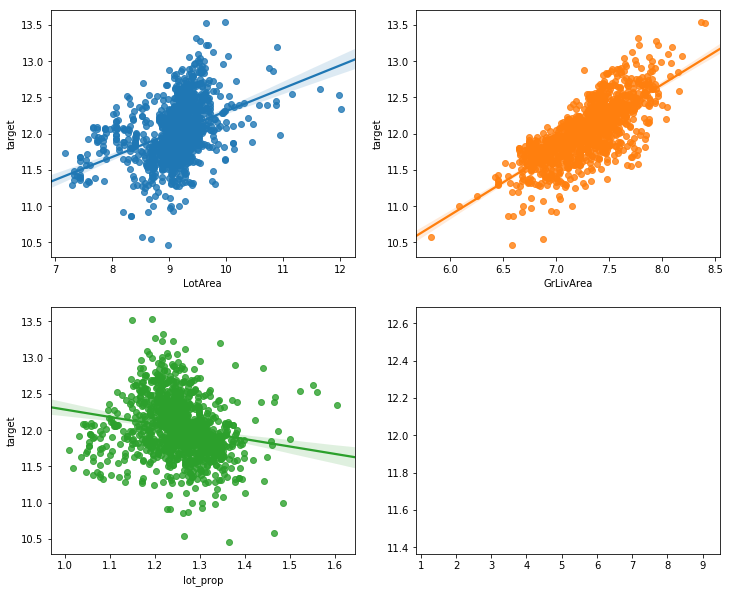

In [42]:
def lot_prop(data):
    data['lot_prop'] = data['LotArea'] / data['GrLivArea']
    return data

train_cleaned = lot_prop(train_cleaned)

exp.corr_target(data=train_cleaned,
                cols=['LotArea', 'GrLivArea', 'lot_prop'],
                target='target')

Nothing game-changing here but, with the same spirity, we can see what role what we can call service areas (Basement and Garage) are playing.

              TotalBsmtSF  GarageArea  service_area    target
TotalBsmtSF      1.000000    0.474743      0.941255  0.641253
GarageArea       0.474743    1.000000      0.744070  0.673793
service_area     0.941255    0.744070      1.000000  0.745304
target           0.641253    0.673793      0.745304  1.000000


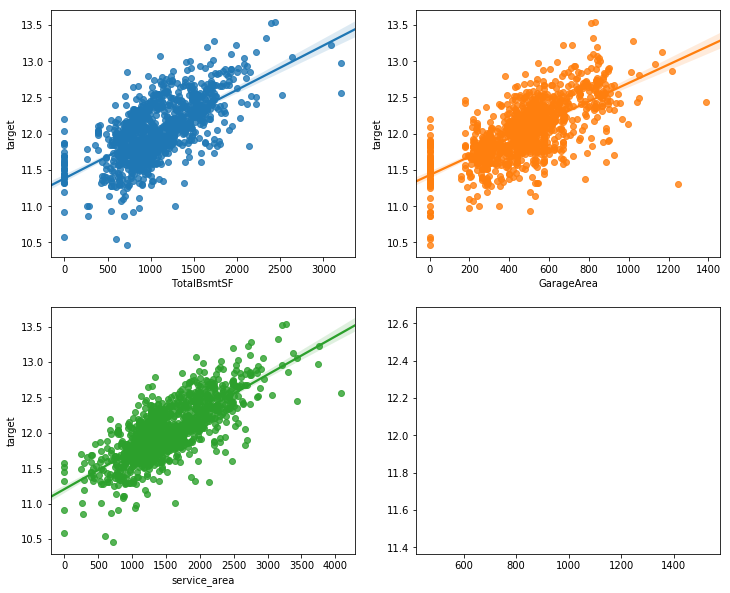

In [43]:
def service_area(data):
    data['service_area'] = data['TotalBsmtSF'] + data['GarageArea']
    return data

train_cleaned = service_area(train_cleaned)

exp.corr_target(data=train_cleaned,
                cols=['TotalBsmtSF', 'GarageArea', 'service_area'],
                target='target')

Since we already have GarageCars to describe the Garage and this new feature is very correlated with the basement SF, we could consider if it is better to use it and drop the original two.

At last, for now, we can use a very powerful but dangerous encoding technique to make a better use of `Neighborhood`. We want to use *target encoding* and, as we will see, it will give us a very predictive feature. However, one must be cautious about using this kind of encoding as it easily lead to severe overfitting.

Two things can prevent the overfitting: the use of pipeline (so we are sure that the encoding happens only on the training set) and some smoothing techniques (so that there is some noise in the feature and the signal is not unrealistically clean). We will implement these features shortly but, for now, we explore the possibilities we have.

                     GrLivArea  Neig_target_mean  Neig_target_std  \
GrLivArea             1.000000          0.472654         0.069002   
Neig_target_mean      0.472654          1.000000        -0.005510   
Neig_target_std       0.069002         -0.005510         1.000000   
Neig_GrLivArea_mean   0.539327          0.876378         0.127942   
Neig_GrLivArea_std   -0.200661         -0.485380         0.467475   
target                0.741597          0.754919        -0.004160   

                     Neig_GrLivArea_mean  Neig_GrLivArea_std    target  
GrLivArea                       0.539327           -0.200661  0.741597  
Neig_target_mean                0.876378           -0.485380  0.754919  
Neig_target_std                 0.127942            0.467475 -0.004160  
Neig_GrLivArea_mean             1.000000           -0.372058  0.661594  
Neig_GrLivArea_std             -0.372058            1.000000 -0.366422  
target                          0.661594           -0.366422  1.000000  


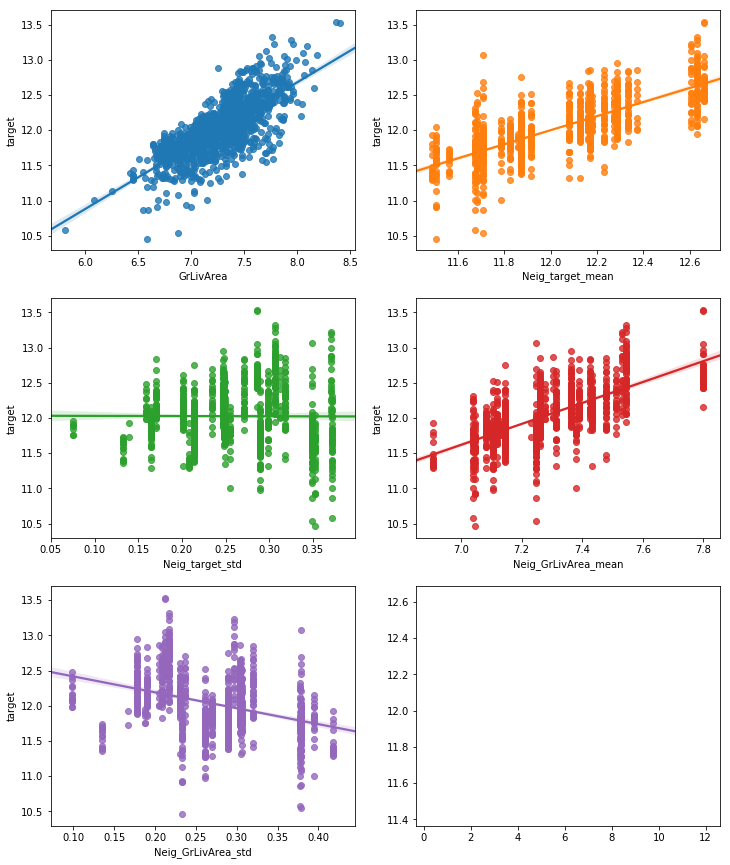

In [44]:
def tr_neighborhood(data, y=None):
    # mean and standard deviation of the price per Neighborhood
    means = data.groupby('Neighborhood')['target'].mean()
    stds = data.groupby('Neighborhood')['target'].std()
    data['Neig_target_mean'] = data['Neighborhood'].map(means)
    data['Neig_target_std'] = data['Neighborhood'].map(stds)
    # mean and standard deviation of the house size per Neighborhood
    means = data.groupby('Neighborhood')['GrLivArea'].mean()
    stds = data.groupby('Neighborhood')['GrLivArea'].std()
    data['Neig_GrLivArea_mean'] = data['Neighborhood'].map(means)
    data['Neig_GrLivArea_std'] = data['Neighborhood'].map(stds)
    
    return data

train_cleaned = tr_neighborhood(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['GrLivArea',
                                          'Neig_target_mean','Neig_target_std',
                                          'Neig_GrLivArea_mean', 'Neig_GrLivArea_std' 
                                          ])

It looks like the target encoding with the mean is very powerful and not very correlated with the other features. We will use this one.

The same could be done with MSSubclass, being a very mysterious feature.

                     GrLivArea  MSSC_target_mean  MSSC_target_std  \
GrLivArea             1.000000          0.475976        -0.001896   
MSSC_target_mean      0.475976          1.000000         0.143940   
MSSC_target_std      -0.001896          0.143940         1.000000   
MSSC_GrLivArea_mean   0.659202          0.722050        -0.002876   
MSSC_GrLivArea_std   -0.170948         -0.173036         0.581542   
target                0.741597          0.585262         0.084243   

                     MSSC_GrLivArea_mean  MSSC_GrLivArea_std    target  
GrLivArea                       0.659202           -0.170948  0.741597  
MSSC_target_mean                0.722050           -0.173036  0.585262  
MSSC_target_std                -0.002876            0.581542  0.084243  
MSSC_GrLivArea_mean             1.000000           -0.259326  0.422588  
MSSC_GrLivArea_std             -0.259326            1.000000 -0.101272  
target                          0.422588           -0.101272  1.000000  


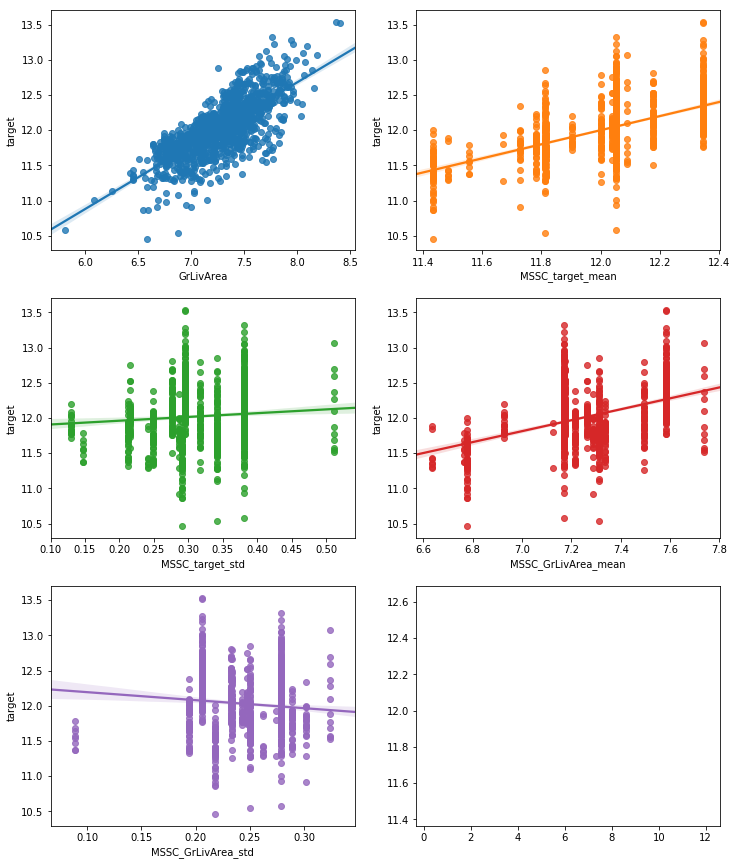

In [45]:
def tr_mssubclass(data, y=None):
    # mean and standard deviation of the price per Neighborhood
    means = data.groupby('MSSubClass')['target'].mean()
    stds = data.groupby('MSSubClass')['target'].std()
    data['MSSC_target_mean'] = data['MSSubClass'].map(means)
    data['MSSC_target_std'] = data['MSSubClass'].map(stds)
    # mean and standard deviation of the house size per Neighborhood
    means = data.groupby('MSSubClass')['GrLivArea'].mean()
    stds = data.groupby('MSSubClass')['GrLivArea'].std()
    data['MSSC_GrLivArea_mean'] = data['MSSubClass'].map(means)
    data['MSSC_GrLivArea_std'] = data['MSSubClass'].map(stds)
    
    return data

train_cleaned = tr_mssubclass(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['GrLivArea',
                                          'MSSC_target_mean','MSSC_target_std',
                                          'MSSC_GrLivArea_mean', 'MSSC_GrLivArea_std' 
                                          ])

Not as evident as before but the mean target encoding looks promising. Being a very sparse feature, we will need to be careful with this encoding as there are a few very rare features and this, as mentioned before, will lead to overfitting (especially with some algorithms).


## Feature selection

We have seen from the previous models already that some features do not look important at all. Not only they slow down the learning, but they can even make our models learn the wrong relationships. We thus now modify the pipeline in order to get rid of these features (it also makes the processing a bit quicker, computation-wise)

In [46]:
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline
    '''
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = X['YearBuilt']  # if no garage, use the age of the building
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        # not useful features
        del X['Id']
        del X['MiscFeature']  # we already know it doesn't matter
        del X['Condition1']
        del X['Condition2']
        del X['Exterior1st']
        del X['Exterior2nd']
        del X['Functional']
        del X['Heating']
        del X['PoolQC']
        del X['RoofMatl']
        del X['RoofStyle']
        del X['SaleCondition']
        del X['SaleType']
        del X['Utilities']
        del X['BsmtFinType1']
        del X['BsmtFinType2']
        del X['BsmtFinSF1']
        del X['BsmtFinSF2']
        del X['Electrical']
        del X['Foundation']
        del X['Street']
        del X['Fence']
        del X['LandSlope']
        del X['LowQualFinSF']
        del X['FireplaceQu']
        del X['PoolArea']
        del X['MiscVal']
        del X['MoSold']
        del X['YrSold']
        
         # after model iterations
        del X['KitchenAbvGr']
        del X['GarageQual']
        del X['GarageCond'] 
        
        return X

The choice was driven by a combination of factors, for example:

* the feature has mainly one value
* the feature does not display any particular pattern (and we want to keep the model simple)
* The feature should not play a role in determining the cost (this comes with the knowledge and biases of the author)

Then there is a number of feature we want to create and we are not particularly sure if they will be helpful or not. For example, we have seen that some features can be safely converted into ordinal ones but others do not display an equally clear pattern and might be more useful as dummies. As another example, we created a new feature for the total number of baths and it looks promising but we are not sure if it is worth dropping all the other original features in its favor. 

We can stay here all day trying to think about the right combination of transformations we need for the optimal set of features but we are getting better in the use of pipelines, it is time to exploit that.

We can design our transformers in order to have parameters that determine whether or not a feature should be transformed/created. In this way, we can tune those parameters with GridSearch or RandomSearch and obtain the best set for every model.

*Note: the code is hidden but rich of insights (or so I like to believe), feel free to expand the next cell*

In [47]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True, bedroom=True, bath=True, lot=True, service=True):
        self.columns = []  # useful to well behave with FeatureUnion
        self.SF_room = SF_room
        self.bedroom = bedroom
        self.bath = bath
        self.lot = lot
        self.service = service
     

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X


    def SF_per_room(self, X):
        if self.SF_room:
            X['sf_per_room'] = X['GrLivArea'] / X['TotRmsAbvGrd']
        return X


    def bedroom_prop(self, X):
        if self.bedroom:
            X['bedroom_prop'] = X['BedroomAbvGr'] / X['TotRmsAbvGrd']
            del X['BedroomAbvGr'] # the new feature makes it redundant and it is not important
        return X


    def total_bath(self, X):
        if self.bath:
            X['total_bath'] = (X[[col for col in X.columns if 'FullBath' in col]].sum(axis=1) +
                             0.5 * X[[col for col in X.columns if 'HalfBath' in col]].sum(axis=1))
            del X['FullBath']  # redundant 

        del X['HalfBath']  # not useful anyway
        del X['BsmtHalfBath']
        del X['BsmtFullBath']
        return X


    def lot_prop(self, X):
        if self.lot:
            X['lot_prop'] = X['LotArea'] / X['GrLivArea']
        return X 


    def service_area(self, X):
        if self.service:
            X['service_area'] = X['TotalBsmtSF'] + X['GarageArea']
            del X['TotalBsmtSF']
            del X['GarageArea']
        return X
    

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
            X = self.remove_skew(X, col)

        X = self.SF_per_room(X)
        X = self.bedroom_prop(X)
        X = self.total_bath(X)
        X = self.lot_prop(X)
        X = self.service_area(X)

        self.columns = X.columns
        return X
    

    def get_feature_names(self):
        return self.columns
    
    
class drop_columns(BaseEstimator, TransformerMixin):
    '''
    Drops columns that are not useful for the model
    The decisions come from several iterations
    '''
    def __init__(self, lasso=False, ridge=False, forest=False, xgb=False, lgb=False):
        self.columns = []
        self.lasso = lasso
        self.ridge = ridge
        self.forest = forest
        self.xgb = xgb
        self.lgb = lgb
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        to_drop = [col for col in X.columns if 'NoGrg' in col]  # dropping dummies that are redundant
        to_drop += [col for col in X.columns if 'NoBsmt' in col]

        if self.lasso:
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col]
            to_drop += [col for col in X.columns if 'HouseStyle' in col] 
            to_drop += [col for col in X.columns if 'LotShape' in col] 
            to_drop += [col for col in X.columns if 'LotFrontage' in col]
            to_drop += [col for col in X.columns if 'GarageYrBlt' in col] 
            to_drop += [col for col in X.columns if 'GarageType' in col] 
            to_drop += ['OpenPorchSF', '3SsnPorch'] 
        if self.ridge: 
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col] 
            to_drop += [col for col in X.columns if 'LotFrontage' in col]
            to_drop += [col for col in X.columns if 'LotShape' in col] 
            to_drop += [col for col in X.columns if 'HouseStyle' in col] 
            to_drop += [col for col in X.columns if 'GarageYrBlt' in col]
            to_drop += [col for col in X.columns if 'GarageCars' in col] 
            to_drop += [col for col in X.columns if 'BldgType' in col] 
            to_drop += ['OpenPorchSF', '3SsnPorch']
        if self.forest: 
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col] 
            to_drop += ['OpenPorchSF', '3SsnPorch'] 
        if self.xgb:
            to_drop += [col for col in X.columns if 'BsmtExposure' in col]
            to_drop += [col for col in X.columns if 'BsmtCond' in col]
            to_drop += [col for col in X.columns if 'ExterCond' in col]
        if self.lgb: 
            to_drop += [col for col in X.columns if 'LotFrontage' in col] 
            to_drop += [col for col in X.columns if 'HouseStyle' in col]
            to_drop += ['MisBsm'] 
            
        
        for col in to_drop:
            try:
                del X[col]
            except KeyError:
                pass
            
        self.columns = X.columns
        return X
    
    def get_feature_names(self):
        return list(self.columns)
    
    
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and unsure_conversion
    '''
    def __init__(self, cols, extra_cols=None, include_extra='include'):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra  # either include, dummies, or drop (any other option)
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra == 'include':
                self.cols += self.extra_cols
            elif self.include_extra == 'dummies':
                pass
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X
    
    
class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase.
    '''
    def __init__(self, mean_weight=10, te_neig=True, te_mssc=True):
        self.mean_tot = 0
        self.mean_weight = mean_weight
        self.smooth_neig = {}
        self.smooth_mssc = {}
        self.te_neig = te_neig
        self.te_mssc = te_mssc
    
    
    def smooth_te(self, data, target, col):
        tmp_data = data.copy()
        tmp_data['target'] = target
        mean_tot = tmp_data['target'].mean()
        means = tmp_data.groupby(col)['target'].mean()
        counts = tmp_data.groupby(col)['target'].count()

        smooth = ((counts * means + self.mean_weight * mean_tot) / 
                       (counts + self.mean_weight))
        return mean_tot, smooth
    
    def fit(self, X, y):
        if self.te_neig:
            self.mean_tot, self.smooth_neig = self.smooth_te(data=X, target=y, col='Neighborhood')

        if self.te_mssc:
            self.mean_tot, self.smooth_mssc = self.smooth_te(X, y, 'MSSubClass')
            
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                     'CarPort': 'Detchd',
                                                     '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_LandSlope(self, data):
        fil = (data.LandSlope != 'Gtl')
        data['LandSlope'] = 0
        data.loc[fil, 'LandSlope'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf',
                                                     '2.5Fin': '2Story',
                                                     '2.5Unf': '2Story',
                                                     'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data


    def tr_Neighborhood(self, data):
        if self.te_neig:
            data['Neighborhood'] = data['Neighborhood'].map(self.smooth_neig).fillna(self.mean_tot)
        return data
    
    def tr_MSSubClass(self, data):
        if self.te_mssc:
            data['MSSubClass'] = data['MSSubClass'].map(self.smooth_mssc).fillna(self.mean_tot)
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        X = self.tr_Neighborhood(X)
        X = self.tr_MSSubClass(X)
        return X

In [48]:
numeric_pipe = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify())])


processing_pipe = dfp.FeatureUnion_df(transformer_list=[('cat', cat_pipe),
                                                 ('num', numeric_pipe)])


full_pipe = Pipeline([('gen_cl', general_cleaner()), 
                      ('proc', processing_pipe), 
                      ('scaler', dfp.df_scaler()), 
                      ('dropper', drop_columns())])

tmp = train_set.copy()

tmp = full_pipe.fit_transform(tmp, y)  # we need to provide y too for the target encoding

tmp.head()

MSSubClass     Alley  LotShape  LandContour  Neighborhood  ExterQual  \
1231   -1.045296 -0.260318  0.739202     -0.24691     -0.586959  -0.691394   
1456    0.070792 -0.260318  0.739202     -0.24691     -0.586959  -0.691394   
242    -1.027304 -0.260318  0.739202     -0.24691     -1.154642  -0.691394   
93     -1.048107 -0.260318  0.739202     -0.24691     -1.154642  -0.691394   
1268   -1.027304 -0.260318  0.739202     -0.24691     -0.586959  -0.691394   

      ExterCond  BsmtQual  BsmtCond  BsmtExposure  HeatingQC  KitchenQual  \
1231        0.0 -3.956431       0.0           0.0  -1.195302    -0.766243   
1456        0.0 -0.547664       0.0           0.0  -0.153656     0.737864   
242         0.0 -0.547664       0.0           0.0  -0.153656    -0.766243   
93          0.0 -0.547664       0.0           0.0   0.887990    -0.766243   
1268        0.0 -0.547664       0.0           0.0  -1.195302    -0.766243   

      MSZoning_RL  MSZoning_RM  LotConfig_Corner  LotConfig_CulDSac  \
1231     0.523753    -0.523753          1.954017          -0.265908   
1456     0.523753    -0.523753         -0.511766          -0.265908   
242     -1.909298     1.909298          1.954017          -0.265908   
93      -1.909298     1.909298          1.954017          -0.265908   
1268     0.523753    -0.523753         -0.511766          -0.265908   

      LotConfig_Inside  BldgType_1Fam  BldgType_Duplex  BldgType_TwnhsE  \
1231         -1.629470      -2.245318         4.018340        -0.346521   
1456          0.613696       0.445371        -0.248859        -0.346521   
242          -1.629470       0.445371        -0.248859        -0.346521   
93           -1.629470      -2.245318         4.018340        -0.346521   
1268          0.613696       0.445371        -0.248859        -0.346521   

      HouseStyle_1.5Unf  HouseStyle_1Story  HouseStyle_2Story  \
1231          -0.358819           1.015558          -0.692600   
1456          -0.358819           1.015558          -0.692600   
242            2.786919          -0.984680          -0.692600   
93            -0.358819          -0.984680           1.443834   
1268           2.786919          -0.984680          -0.692600   

      HouseStyle_SFoyer  MasVnrType_BrkFace  MasVnrType_None  \
1231           -0.27323            -0.67235         0.808641   
1456           -0.27323            -0.67235         0.808641   
242            -0.27323            -0.67235         0.808641   
93             -0.27323            -0.67235         0.808641   
1268           -0.27323             1.48732        -1.236642   

      MasVnrType_Stone  CentralAir_N  CentralAir_Y  GarageType_Attchd  \
1231          -0.30292     -0.271413      0.271413          -1.236642   
1456          -0.30292     -0.271413      0.271413           0.808641   
242           -0.30292      3.684427     -3.684427           0.808641   
93            -0.30292      3.684427     -3.684427          -1.236642   
1268          -0.30292     -0.271413      0.271413           0.808641   

      GarageType_BuiltIn  GarageType_Detchd  GarageFinish_Fin  \
1231           -0.264054           1.625961          -0.55952   
1456           -0.264054          -0.615021          -0.55952   
242            -0.264054          -0.615021          -0.55952   
93             -0.264054           1.625961          -0.55952   
1268           -0.264054          -0.615021          -0.55952   

      GarageFinish_RFn  GarageFinish_Unf  PavedDrive_N  PavedDrive_P  \
1231         -0.636254          1.180784     -0.256541      -0.15102   
1456         -0.636254          1.180784     -0.256541      -0.15102   
242          -0.636254          1.180784     -0.256541      -0.15102   
93           -0.636254          1.180784     -0.256541      -0.15102   
1268         -0.636254          1.180784     -0.256541      -0.15102   

      PavedDrive_Y  LotFrontage   LotArea  OverallQual  OverallCond  \
1231       0.30292     0.378144  0.178389    -1.532470    -0.520843   
1456       0.30

We are now ready to use these parameters in our search or the optimal model.

# Hyperparameter tuning

The key, and for some the novelty, of this phase is to tune both the parameters of the chosen algorithm (like the regularization in `Lasso`) and the one controlling on the creation of new features or on how to scale the data at the same time.

It is important, as before, to not fall too deep into the rabbit hole we need to be pragmatic. Most of the parameters we want to tune will have such a small influence on the model and such a high cost in terms of computation time that we have to be able to explore the sections of the parameter space that really matter.

To achieve that, it is a good practice to quickly iterate on different configurations and keep track of the effects of our choices. Even if this means coming back to the previous section and create something new. Depending on when you read this notebook, you will see different iterations of this phase (or probably the final iteration). I will try to explain as good as I can why some things were done and some other weren't.

As of now, the full pipeline (without the model) looks like this.

In [49]:
full_pipe.get_params()

{'memory': None,
 'steps': [('gen_cl', general_cleaner()), ('proc', FeatureUnion_df(n_jobs=None,
                   transformer_list=[('cat',
                                      Pipeline(memory=None,
                                               steps=[('fs',
                                                       feat_sel(dtype='category')),
                                                      ('imp',
                                                       df_imputer(strategy='most_frequent')),
                                                      ('ord',
                                                       make_ordinal(cols=['BsmtQual',
                                                                          'KitchenQual',
                                                                          'ExterQual',
                                                                          'HeatingQC',
                                                                          'BsmtExposur

Pretty cumbersome but at the bottom of it we have all the hyperparameters we want to tune. Let's tune model by model.

## Tuning Lasso

As a reminder, in the model selection phase we have as a baseline for Lasso given by

In [50]:
results.loc[results.model_name=='lasso', ]

model_name  rmse_train  rmse_test     mae_train     mae_test
0      lasso    0.015047   0.018563  15672.486562  16698.57247

Let's then create a pipeline for this model

In [51]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_pipe),
                       ('scaler', dfp.df_scaler()),
                       ('dropper', drop_columns()), 
                       ('lasso', Lasso(alpha=0.01))])

The parameter space I want to explore, searching for the best configuration, is

In [52]:
lasso_params = {'lasso__alpha': [0.05, 0.01, 0.005, 0.001], 
                'lasso__tol': [0.005, 0.001, 0.0005, 0.0001],
                'proc__cat__dummies__drop_first': [True, False], 
                'proc__cat__recode__te_mssc': [True, False], 
                'proc__cat__recode__te_neig': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False], 
                'proc__num__transf__bath': [True, False], 
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False], 
                'proc__num__transf__service': [True, False],
                'scaler__method': ['standard', 'robust'], 
                'dropper__drop': [True, False]}

These are 32768 different configurations to test on 5 folds. Even though Lasso is pretty quick and the data are not big, it can take quite a long time.

After a few iterations, and this is the last time I put all the steps of the process or this notebook becomes unbearable, we can restrict our search a bit. Namely,

* All the target encoding is giving higher score
* Dropping the variables at the end is never helpful
* The alpha parameter has to be searched on a different range
* The service area does not help
* total_bath always helps

These are still a lot of configurations. We will thus test only 200 random combinations

In [53]:
lasso_params = {'lasso__alpha': [0.002, 0.001, 0.0009, 0.0008], 
                'lasso__tol': [0.005, 0.001, 0.0005, 0.0001],
                'proc__cat__dummies__drop_first': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False],
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False],
                'scaler__method': ['standard', 'robust']}

In [54]:
result_lasso, bp_lasso, best_lasso = grid_search(train_set, y, lasso_pipe, 
                                                 param_grid=lasso_params, cv=folds, scoring='neg_mean_squared_error', 
                                                 random=100)

# todo: apparently dropping the extra columns to transform to ordinal gives problems. It has to be fixed

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [55]:
result_lasso.head(10)

param_scaler__method param_proc__num__transf__lot  \
0             standard                        False   
1             standard                         True   
2             standard                         True   
3             standard                        False   
4             standard                         True   
5             standard                        False   
6             standard                         True   
7             standard                        False   
8             standard                         True   
9             standard                        False   

  param_proc__num__transf__bedroom param_proc__num__transf__SF_room  \
0                            False                            False   
1                            False                             True   
2                            False                            False   
3                            False                            False   
4                            False                            False   
5                            False                             True   
6                            False                            False   
7                            False                            False   
8                            False                             True   
9                             True                             True   

  param_proc__cat__ord__include_extra param_proc__cat__dummies__drop_first  \
0                             include                                 True   
1                             dummies                                 True   
2                             include                                 True   
3                             dummies                                 True   
4                             dummies                                 True   
5                             dummies                                 True   
6                             include                                 True   
7                             dummies                                 True   
8                             include                                 True   
9                             include                                 True   

  param_lasso__tol param_lasso__alpha  mean_test_score  std_test_score  \
0            0.005              0.001        -0.013884        0.001175   
1            0.001              0.001        -0.013885        0.001185   
2            0.001              0.001        -0.013885        0.001185   
3           0.0005              0.001        -0.013886        0.001186   
4           0.0005              0.001        -0.013886        0.001186   
5            0.001              0.001        -0.013887        0.001186   
6           0.0001              0.001        -0.013887        0.001186   
7           0.0001              0.001        -0.013887        0.001186   
8           0.0001             0.0009        -0.013894        0.001174   
9            0.005              0.001        -0.013898        0.001187   

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  
0       0.566405      0.021153         0.388937        0.068704  
1       0.568529      0.034087         0.335629        0.032514  
2       0.584701      0.017304         0.337599        0.005569  
3       0.544481      0.027917         0.322612        0.020347  
4       0.552364      0.019578         0.309652        0.011062  
5       0.535211      0.025873         0.306811        0.011104  
6       0.608086      0.027980         0.353773        0.031865  
7       0.685980      0.087123         0.315841        0.018926  
8       0.568547      0.013721         0.343666        0.018362  
9       0.569238      0.013505         0.348685        0.026725

After this search, the best configuration is given by

In [56]:
bp_lasso

{'scaler__method': 'standard',
 'proc__num__transf__lot': False,
 'proc__num__transf__bedroom': False,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True,
 'lasso__tol': 0.005,
 'lasso__alpha': 0.001}

The model has now these coefficients

In [57]:
get_coef(best_lasso)

feat     score
31         OverallQual  0.083025
53        service_area  0.080007
39           GrLivArea  0.049774
37            1stFlrSF  0.049554
38            2ndFlrSF  0.049419
4         Neighborhood  0.044640
32         OverallCond  0.043354
33           YearBuilt  0.032389
30             LotArea  0.028949
36           BsmtUnfSF -0.024968
7             BsmtQual  0.020052
42          Fireplaces  0.018598
52          total_bath  0.017799
11         KitchenQual  0.014973
10           HeatingQC  0.014147
34        YearRemodAdd  0.013951
5            ExterQual  0.013857
0           MSSubClass  0.012683
22        CentralAir_Y  0.012536
49         ScreenPorch  0.010799
50              MisBsm  0.009861
51           MisGarage -0.009327
41        TotRmsAbvGrd  0.009059
12         MSZoning_RM -0.008774
28        PavedDrive_Y  0.008656
45          WoodDeckSF  0.007347
21    MasVnrType_Stone  0.007237
35          MasVnrArea  0.007077
20     MasVnrType_None  0.006817
47       EnclosedPorch  0.005920
3          LandContour  0.005774
40        BedroomAbvGr -0.005645
13   LotConfig_CulDSac  0.005310
25    GarageFinish_RFn -0.005296
24   GarageType_Detchd  0.004138
15     BldgType_Duplex -0.003167
19   HouseStyle_SFoyer  0.003109
26    GarageFinish_Unf -0.002899
1                Alley  0.002664
16     BldgType_TwnhsE -0.002625
44          GarageCars  0.001984
46         OpenPorchSF  0.001593
23  GarageType_BuiltIn  0.001387
29         LotFrontage  0.001232
27        PavedDrive_P  0.001045
43         GarageYrBlt  0.000000
6            ExterCond  0.000000
8             BsmtCond  0.000000
48           3SsnPorch  0.000000
9         BsmtExposure  0.000000
14    LotConfig_Inside  0.000000
17   HouseStyle_1Story -0.000000
2             LotShape -0.000000
18   HouseStyle_2Story -0.000000

While the performance on our test set (which should not influence our hyperparameter tuning but it is nice to keep track of its evolution) is

Test set RMSE: 0.1263
Test set MAE: 14591.37


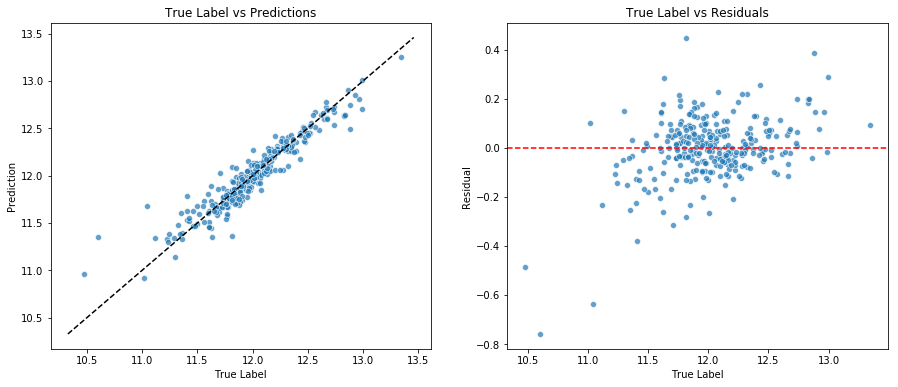

In [58]:
tmp = test_set.copy()
preds = best_lasso.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

To come back to the spirit of the Kaggle competition, this result is extremely close to the one that you obtain in public leaderboard if you simply predict on the provided test set. This would approximatevely score in the top 34% and, if we retrain on the full test, top 31%. This is not very competitive but the good news is that we can focus on increase this cross validated result to also obtain a better score in the competition. 

After a few iterations, we get rid of the features that are not helpful and with the *final* pipeline for Lasso

In [59]:
numeric_lasso = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(lot=False, 
                                               bedroom=False, 
                                               SF_room=False))])

cat_lasso = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_lasso = dfp.FeatureUnion_df(transformer_list=[('cat', cat_lasso),
                                                 ('num', numeric_lasso)])

lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lasso),
                       ('scaler', dfp.df_scaler(method='standard')),
                       ('dropper', drop_columns(lasso=True)), 
                       ('lasso', Lasso(alpha=0.001, tol=0.005))])

With coefficients

In [60]:
lasso_oof, coefs = cv_score(train_set, y, folds, lasso_pipe, imp_coef=True)

coefs

mean       std
feat                                 
OverallQual        0.083286  0.003093
service_area       0.078932  0.002313
2ndFlrSF           0.049664  0.006035
1stFlrSF           0.049538  0.006489
GrLivArea          0.048768  0.008201
Neighborhood       0.044442  0.003186
OverallCond        0.043416  0.002327
YearBuilt          0.031246  0.004268
LotArea            0.029090  0.002211
BsmtUnfSF         -0.025040  0.000229
BsmtQual           0.020908  0.004821
Fireplaces         0.018281  0.002342
total_bath         0.018250  0.002510
KitchenQual        0.015192  0.001273
HeatingQC          0.014358  0.003068
ExterQual          0.013959  0.001817
YearRemodAdd       0.013712  0.005291
CentralAir_Y       0.012592  0.002695
MSSubClass         0.011764  0.004268
ScreenPorch        0.011023  0.001601
MisBsm             0.010343  0.003397
MisGarage         -0.010136  0.002057
TotRmsAbvGrd       0.009717  0.004296
MSZoning_RM       -0.008700  0.004292
PavedDrive_Y       0.008688  0.002509
MasVnrArea         0.007347  0.001755
WoodDeckSF         0.007198  0.002573
MasVnrType_None    0.007037  0.001617
MasVnrType_Stone   0.007021  0.000829
BedroomAbvGr      -0.005941  0.002553
EnclosedPorch      0.005905  0.001436
LandContour        0.005607  0.001232
GarageFinish_RFn  -0.005515  0.003057
LotConfig_CulDSac  0.005048  0.001325
BldgType_TwnhsE   -0.003349  0.001984
GarageCars         0.003290  0.002773
BldgType_Duplex   -0.003194  0.002993
Alley              0.002986  0.001791
GarageFinish_Unf  -0.001992  0.002048
PavedDrive_P       0.001067  0.001273
LotConfig_Inside   0.000208  0.000543

And the following in fold and out of fold predictions

Train set RMSE: 0.1173
Train set MAE: 14797.63
Test set RMSE: 0.1264
Test set MAE: 14635.4


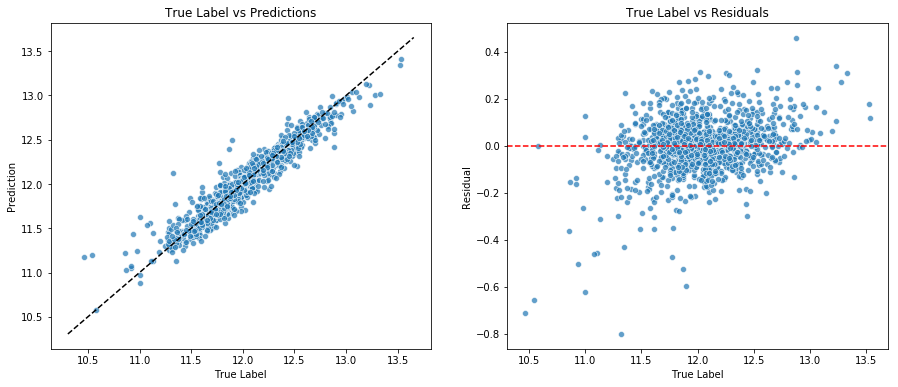

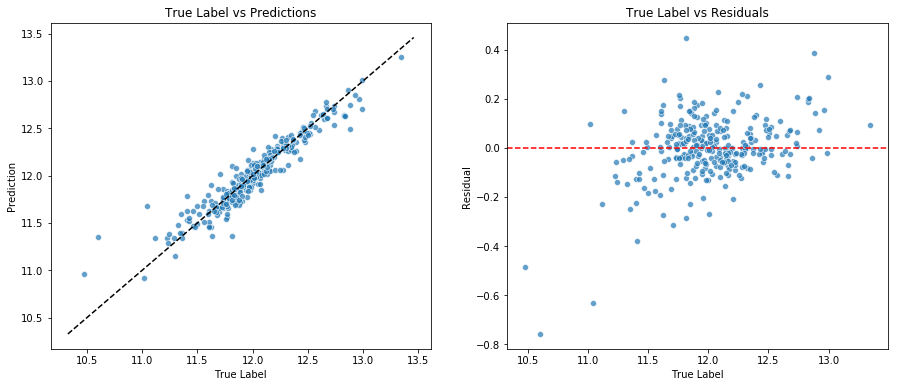

In [61]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, lasso_oof)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(lasso_oof)), 2)}')
plot_predictions(train_set, y, lasso_oof)

tmp = train_set.copy()
lasso_pipe.fit(tmp, y)
tmp = test_set.copy()
preds = lasso_pipe.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

Our effort of tuning Lasso a bit more, considering the creation of features and their selection as part of the tuning, led to an improvement of the model performance from the original 0.123 to the current 0.117. In terms of mean absolute error, we go from a little bit more than 15000 dollars to a bit less than 15000. In a real project, it is a good idea to keep track of the time and effort we put in fine tuning our model and evaluate if the project gets a significant benefit from this time and effort.

In this case, the tuning took us not more than 2 hours and a model that is about 1000 dollars more accurate is worth 2 hours of work.

To be fair, we should not compare the results obtained on the training set. Even though we are using our pipeline and k-fold cross-validation, some information is leaking from the training folds to the test folds in the form of our decisions iteration after iteration. In other words, each iteration we tweak the model to get a better score and this is a good strategy to tune it. However, we are, in a sense, *overfitting the test* folds.

Therefore a proper indication of what our model is doing can only come from the test set. It is very important that we use this set only to monitor the performance and not to take further modeling decisions or we risk of overfitting that set too.

On the test set, the model improved of 0.009 in RMSE (7% better) and of about 2000 dollars (12% better).

## Tuning Ridge

The strategy stays the same

In [62]:
results.loc[results.model_name=='ridge', ]

model_name  rmse_train  rmse_test     mae_train      mae_test
1      ridge     0.01488   0.017026  15277.383858  15349.278567

In [63]:
ridge_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_pipe),
                       ('scaler', dfp.df_scaler()),
                       ('dropper', drop_columns()), 
                       ('ridge', Ridge())])

* the bedroom proportion is never helping
* dropping variables never helps
* target encoding always help

In [64]:
ridge_params = {'ridge__alpha': [2, 1.7, 1.5, 1.3, 1, 0.9], 
                'ridge__tol': [0.005, 0.001, 0.0005, 0.0001],
                'proc__cat__dummies__drop_first': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False],
                'proc__num__transf__lot': [True, False],
                'scaler__method': ['standard', 'robust']}

In [65]:
result_ridge, bp_ridge, best_ridge = grid_search(train_set, y, ridge_pipe, 
                                                 param_grid=ridge_params, cv=folds, scoring='neg_mean_squared_error', 
                                                 random=100)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [66]:
result_ridge.head(10)

param_scaler__method param_ridge__tol param_ridge__alpha  \
0               robust           0.0001                  2   
1               robust            0.001                1.7   
2               robust            0.005                1.5   
3               robust           0.0005                1.5   
4               robust           0.0001                1.5   
5               robust           0.0005                1.5   
6               robust           0.0001                1.5   
7               robust            0.001                1.5   
8               robust            0.001                1.5   
9               robust           0.0005                1.3   

  param_proc__num__transf__lot param_proc__num__transf__SF_room  \
0                         True                            False   
1                         True                             True   
2                         True                            False   
3                         True                            False   
4                        False                            False   
5                        False                            False   
6                        False                            False   
7                         True                             True   
8                         True                             True   
9                         True                            False   

  param_proc__cat__ord__include_extra param_proc__cat__dummies__drop_first  \
0                             include                                 True   
1                             dummies                                 True   
2                             dummies                                 True   
3                             dummies                                 True   
4                             include                                 True   
5                             include                                 True   
6                             dummies                                 True   
7                             include                                 True   
8                             dummies                                 True   
9                             include                                 True   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0        -0.014038        0.001088       0.594827      0.019603   
1        -0.014048        0.001080       0.550500      0.010325   
2        -0.014049        0.001079       0.642562      0.106115   
3        -0.014049        0.001079       0.636260      0.076447   
4        -0.014051        0.001080       0.759245      0.032989   
5        -0.014051        0.001080       0.793363      0.138564   
6        -0.014051        0.001080       0.550775      0.016262   
7        -0.014053        0.001076       0.710336      0.094439   
8        -0.014053        0.001076       0.576266      0.015200   
9        -0.014054        0.001075       0.602980      0.029952   

   mean_score_time  std_score_time  
0         0.361043        0.047499  
1         0.313112        0.019480  
2         0.333421        0.036018  
3         0.379375        0.043791  
4         0.488637        0.093134  
5         0.452901        0.092271  
6         0.306798        0.009774  
7         0.366331        0.047899  
8         0.307379        0.007749  
9         0.334332        0.009651

In [67]:
bp_ridge

{'scaler__method': 'robust',
 'ridge__tol': 0.0001,
 'ridge__alpha': 2,
 'proc__num__transf__lot': True,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True}

In [68]:
get_coef(best_ridge)

feat     score
31         OverallQual  0.120097
54        service_area  0.101006
38            2ndFlrSF  0.085708
37            1stFlrSF  0.070121
49              MisBsm  0.067319
33           YearBuilt  0.059492
39           GrLivArea  0.053957
4         Neighborhood  0.053808
22        CentralAir_Y  0.048939
50           MisGarage -0.041993
32         OverallCond  0.041091
28        PavedDrive_Y  0.037261
30             LotArea  0.036297
36           BsmtUnfSF -0.034682
21    MasVnrType_Stone  0.031306
41          Fireplaces  0.029164
10           HeatingQC  0.029121
3          LandContour  0.026772
34        YearRemodAdd  0.026654
13   LotConfig_CulDSac  0.025823
7             BsmtQual  0.024715
12         MSZoning_RM -0.024387
20     MasVnrType_None  0.023134
5            ExterQual  0.022782
52          total_bath  0.021534
11         KitchenQual  0.021228
0           MSSubClass  0.020903
27        PavedDrive_P  0.019379
24   GarageType_Detchd  0.018661
19   HouseStyle_SFoyer  0.018566
53            lot_prop -0.017257
25    GarageFinish_RFn -0.016857
15     BldgType_Duplex -0.016480
1                Alley  0.015651
26    GarageFinish_Unf -0.013972
16     BldgType_TwnhsE -0.011618
44          WoodDeckSF  0.011019
35          MasVnrArea  0.009830
40        TotRmsAbvGrd  0.007730
42         GarageYrBlt -0.006697
18   HouseStyle_2Story -0.006240
23  GarageType_BuiltIn  0.005422
17   HouseStyle_1Story  0.005344
51        bedroom_prop -0.005141
43          GarageCars  0.003633
45         OpenPorchSF  0.002815
2             LotShape  0.002558
29         LotFrontage  0.002023
14    LotConfig_Inside  0.001716
48         ScreenPorch  0.000204
46       EnclosedPorch  0.000134
47           3SsnPorch  0.000016
8             BsmtCond  0.000000
6            ExterCond  0.000000
9         BsmtExposure  0.000000

Test set RMSE: 0.126
Test set MAE: 14461.39


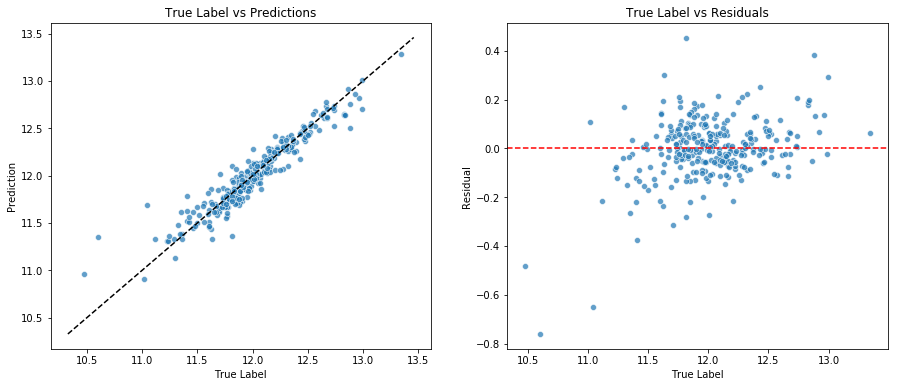

In [69]:
tmp = test_set.copy()
preds = best_ridge.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

Once again, we use these information to iterate a few more times on the various configurations. Here you can see, for example, that we drop a different set of features. The decision was driven by the study of the coefficients in cross-validation. If a coefficient was varying a lot from fold to fold, we performed an iteration without that coefficient and checked if the model was improving.

In [70]:
numeric_ridge = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(SF_room=False))])


cat_ridge = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_ridge = dfp.FeatureUnion_df(transformer_list=[('cat', cat_ridge),
                                                 ('num', numeric_ridge)])

ridge_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_ridge),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(ridge=True)), 
                       ('ridge', Ridge(alpha=2, tol=0.0001))])

The model has then these coefficients

In [71]:
ridge_oof, coefs = cv_score(train_set, y, folds, ridge_pipe, imp_coef=True)

coefs

mean       std
feat                                  
OverallQual         0.122110  0.003205
service_area        0.101880  0.004902
2ndFlrSF            0.083233  0.007869
1stFlrSF            0.075923  0.009317
MisBsm              0.065279  0.015062
YearBuilt           0.054792  0.004413
GrLivArea           0.054087  0.007981
Neighborhood        0.053497  0.003784
CentralAir_Y        0.049293  0.008245
MisGarage          -0.046442  0.005731
OverallCond         0.041386  0.002763
PavedDrive_Y        0.036850  0.007837
BsmtUnfSF          -0.035224  0.000906
LotArea             0.033478  0.005890
MasVnrType_Stone    0.030377  0.003157
HeatingQC           0.029619  0.006692
Fireplaces          0.029485  0.003955
YearRemodAdd        0.026325  0.009766
MSZoning_RM        -0.026118  0.011118
BsmtQual            0.025462  0.005315
LandContour         0.024136  0.003335
MasVnrType_None     0.022892  0.002771
LotConfig_CulDSac   0.022761  0.003252
ExterQual           0.022582  0.003142
KitchenQual         0.022017  0.002027
MSSubClass          0.021103  0.006371
PavedDrive_P        0.017978  0.008202
GarageType_Detchd   0.017621  0.008822
total_bath          0.016984  0.007376
Alley               0.016694  0.006042
GarageFinish_RFn   -0.015807  0.006754
GarageFinish_Unf   -0.014314  0.002935
WoodDeckSF          0.010281  0.003420
MasVnrArea          0.009893  0.001729
lot_prop           -0.009886  0.006984
GarageType_BuiltIn  0.008759  0.005672
TotRmsAbvGrd        0.006929  0.002389
bedroom_prop       -0.004899  0.001757
LotConfig_Inside    0.002332  0.004143
ScreenPorch         0.000210  0.000026
EnclosedPorch       0.000137  0.000025

Train set RMSE: 0.117
Train set MAE: 14821.51
Test set RMSE: 0.1268
Test set MAE: 14592.83


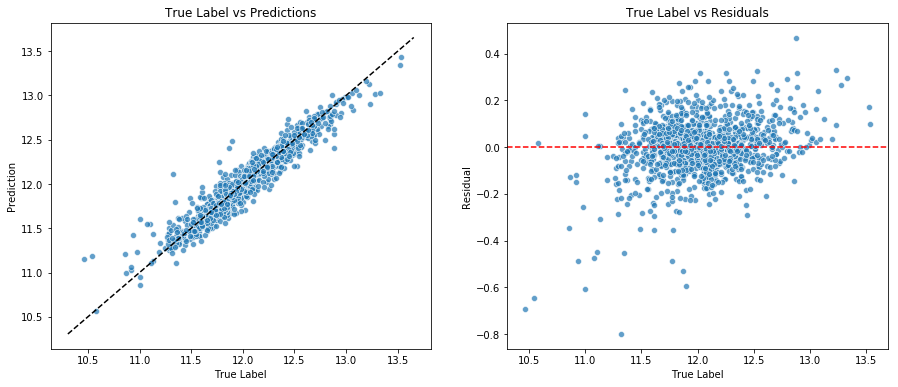

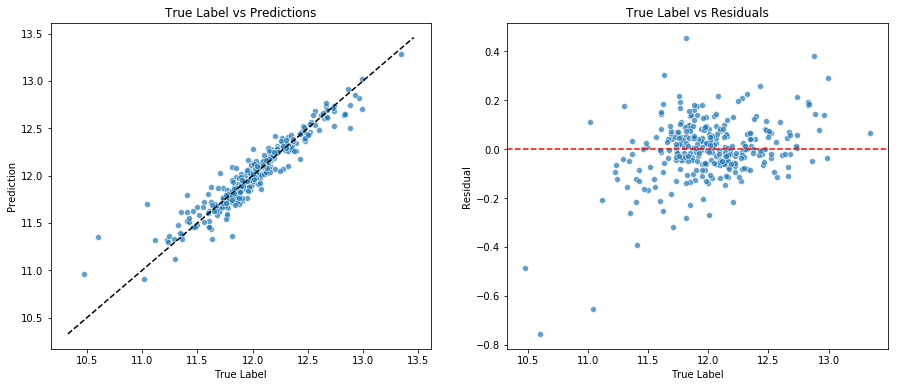

In [72]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, ridge_oof)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(ridge_oof)), 2)}')
plot_predictions(train_set, y, ridge_oof)

tmp = train_set.copy()
ridge_pipe.fit(tmp, y)
tmp = test_set.copy()
preds = ridge_pipe.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

This time our 2 hours of work (I am considering all the iterations made up until this moment) led to a 3% improvement in RMSE and to a model about 1000 dollars more accurate.

## Tuning RandomForest

The scaler should not matter as in general scaling the data for a tree-based algorithm will only increase the speed and not the outcome.

In [73]:
results.loc[results.model_name=='forest', ]

model_name  rmse_train  rmse_test    mae_train      mae_test
3     forest    0.019815   0.023333  17858.98709  17943.617852

In [74]:
forest_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_pipe),
                       ('scaler', dfp.df_scaler()),
                       ('dropper', drop_columns()), 
                       ('forest', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=32))])

* target encoding always helps

In [75]:
forest_params = {'forest__max_depth': [10, 20, 30, None],
                 'forest__max_features': ['auto', 'sqrt', 'log2'], 
                 'forest__min_samples_leaf': [1, 3, 5, 10],
                 'forest__min_samples_split': [2, 4, 6, 8],
                'proc__cat__dummies__drop_first': [True, False],
                'proc__cat__ord__include_extra': ['include', 'dummies'], 
                'proc__num__transf__SF_room': [True, False], 
                'proc__num__transf__bath': [True, False], 
                'proc__num__transf__bedroom': [True, False], 
                'proc__num__transf__lot': [True, False], 
                'proc__num__transf__service': [True, False]}

In [76]:
result_forest, bp_forest, best_forest = grid_search(train_set, y, forest_pipe, 
                                                 param_grid=forest_params, cv=folds, scoring='neg_mean_squared_error', 
                                                 random=100)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [77]:
result_forest.head(10)

param_proc__num__transf__service param_proc__num__transf__lot  \
0                            False                        False   
1                            False                        False   
2                             True                        False   
3                             True                         True   
4                             True                        False   
5                             True                         True   
6                            False                        False   
7                            False                         True   
8                             True                        False   
9                             True                        False   

  param_proc__num__transf__bedroom param_proc__num__transf__bath  \
0                            False                          True   
1                             True                          True   
2                             True                          True   
3                            False                         False   
4                            False                         False   
5                             True                         False   
6                             True                         False   
7                            False                          True   
8                             True                          True   
9                             True                         False   

  param_proc__num__transf__SF_room param_proc__cat__ord__include_extra  \
0                            False                             include   
1                            False                             include   
2                             True                             include   
3                            False                             include   
4                            False                             include   
5                             True                             dummies   
6                            False                             include   
7                            False                             include   
8                            False                             include   
9                             True                             include   

  param_proc__cat__dummies__drop_first param_forest__min_samples_split  \
0                                 True                               2   
1                                False                               6   
2                                 True                               2   
3                                False                               6   
4                                 True                               2   
5                                 True                               2   
6                                False                               2   
7                                False                               8   
8                                 True                               4   
9                                False                               2   

  param_forest__min_samples_leaf param_forest__max_features  \
0                              1                       sqrt   
1                              1                       sqrt   
2                              1                       log2   
3                              1                       sqrt   
4                              1                       log2   
5                              1                       sqrt   
6                              1                       sqrt   
7                              1                       sqrt   
8                              3                       sqrt   
9                              1                       sqrt   

  param_forest__max_depth  mean_test_score  std_test_score  mean_fit_time  \
0                      20        -0.018011        0.002361       1.856667   
1                      20        -0.0

In [78]:
bp_forest

{'proc__num__transf__service': False,
 'proc__num__transf__lot': False,
 'proc__num__transf__bedroom': False,
 'proc__num__transf__bath': True,
 'proc__num__transf__SF_room': False,
 'proc__cat__ord__include_extra': 'include',
 'proc__cat__dummies__drop_first': True,
 'forest__min_samples_split': 2,
 'forest__min_samples_leaf': 1,
 'forest__max_features': 'sqrt',
 'forest__max_depth': 20}

In [79]:
get_feature_importance(best_forest)

feat     score
31         OverallQual  0.131157
40           GrLivArea  0.101533
4         Neighborhood  0.097981
54          total_bath  0.053975
37         TotalBsmtSF  0.050400
5            ExterQual  0.048495
46          GarageArea  0.045904
45          GarageCars  0.045323
33           YearBuilt  0.044733
11         KitchenQual  0.042131
38            1stFlrSF  0.040245
7             BsmtQual  0.030108
44         GarageYrBlt  0.027741
34        YearRemodAdd  0.026774
30             LotArea  0.023875
43          Fireplaces  0.021260
42        TotRmsAbvGrd  0.019010
39            2ndFlrSF  0.017990
0           MSSubClass  0.017793
48         OpenPorchSF  0.009846
36           BsmtUnfSF  0.009663
35          MasVnrArea  0.008656
32         OverallCond  0.008424
29         LotFrontage  0.008043
22        CentralAir_Y  0.007872
10           HeatingQC  0.007502
47          WoodDeckSF  0.006951
41        BedroomAbvGr  0.006001
24   GarageType_Detchd  0.005024
53           MisGarage  0.003841
26    GarageFinish_Unf  0.003126
12         MSZoning_RM  0.003033
2             LotShape  0.002524
18   HouseStyle_2Story  0.002475
49       EnclosedPorch  0.002238
28        PavedDrive_Y  0.002129
25    GarageFinish_RFn  0.001977
17   HouseStyle_1Story  0.001808
51         ScreenPorch  0.001532
20     MasVnrType_None  0.001445
14    LotConfig_Inside  0.001278
3          LandContour  0.001203
15     BldgType_Duplex  0.001044
52              MisBsm  0.001028
16     BldgType_TwnhsE  0.001027
1                Alley  0.000751
21    MasVnrType_Stone  0.000719
13   LotConfig_CulDSac  0.000673
19   HouseStyle_SFoyer  0.000634
23  GarageType_BuiltIn  0.000491
27        PavedDrive_P  0.000318
50           3SsnPorch  0.000298
6            ExterCond  0.000000
8             BsmtCond  0.000000
9         BsmtExposure  0.000000

Test set RMSE: 0.1453
Test set MAE: 16423.77


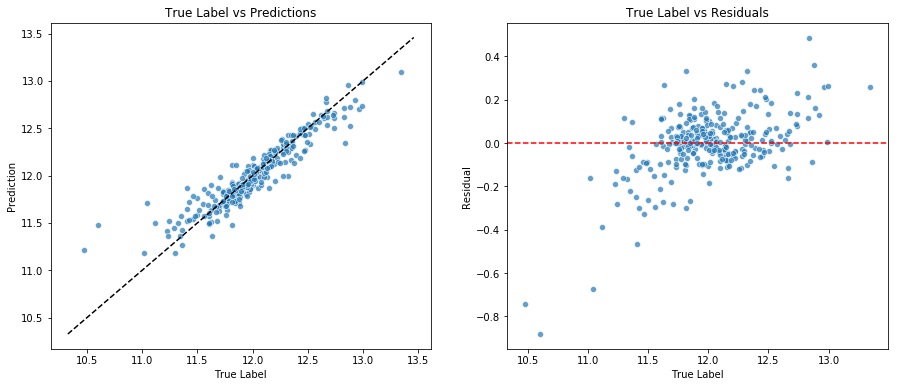

In [80]:
tmp = test_set.copy()
preds = best_forest.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

While the model is not performing very well, it is also very easy to tune (or, to say it better, tuning it doesn't improve it that much). The *final* version of the RandomForest is then

In [81]:
numeric_forest = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(SF_room=False,
                                               bedroom=False, 
                                               lot=False))])


cat_forest = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_forest = dfp.FeatureUnion_df(transformer_list=[('cat', cat_forest),
                                                 ('num', numeric_forest)])

forest_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_forest),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(forest=True)), 
                       ('forest', RandomForestRegressor(n_estimators=1500, max_depth=30, 
                                                        max_features='sqrt',
                                                        n_jobs=-1, random_state=32))])

In [82]:
forest_oof, coefs = cv_score(train_set, y, folds, forest_pipe, imp_coef=True)

coefs

mean       std
feat                                  
OverallQual         0.126223  0.003465
GrLivArea           0.099629  0.002279
service_area        0.093436  0.005467
Neighborhood        0.088920  0.004597
ExterQual           0.062097  0.007247
KitchenQual         0.052535  0.004180
total_bath          0.051098  0.009564
1stFlrSF            0.043344  0.002397
YearBuilt           0.042006  0.003627
GarageCars          0.039692  0.001832
BsmtQual            0.032354  0.003042
GarageYrBlt         0.027460  0.001516
LotArea             0.025741  0.002756
YearRemodAdd        0.024677  0.002140
MSSubClass          0.022756  0.001964
Fireplaces          0.020950  0.002790
TotRmsAbvGrd        0.020123  0.001718
2ndFlrSF            0.019516  0.001834
BsmtUnfSF           0.010066  0.000161
LotFrontage         0.009600  0.000520
OverallCond         0.009026  0.000875
MasVnrArea          0.008633  0.001049
CentralAir_Y        0.007675  0.001659
HeatingQC           0.007017  0.001048
WoodDeckSF          0.006687  0.000206
BedroomAbvGr        0.006187  0.000483
MisGarage           0.004686  0.000773
GarageType_Detchd   0.004153  0.000368
GarageFinish_Unf    0.003754  0.000405
MSZoning_RM         0.003156  0.000623
LotShape            0.002576  0.000362
HouseStyle_2Story   0.002541  0.000171
PavedDrive_Y        0.002273  0.000549
HouseStyle_1Story   0.002218  0.000222
MasVnrType_None     0.002179  0.000347
EnclosedPorch       0.002159  0.000167
GarageFinish_RFn    0.001742  0.000135
ScreenPorch         0.001662  0.000165
LotConfig_Inside    0.001283  0.000075
LandContour         0.001229  0.000168
BldgType_TwnhsE     0.001112  0.000066
MasVnrType_Stone    0.000925  0.000149
BldgType_Duplex     0.000900  0.000041
Alley               0.000876  0.000105
MisBsm              0.000849  0.000065
LotConfig_CulDSac   0.000715  0.000080
GarageType_BuiltIn  0.000631  0.000088
HouseStyle_SFoyer   0.000580  0.000087
PavedDrive_P        0.000355  0.000069

Train set RMSE: 0.132
Train set MAE: 16505.39
Test set RMSE: 0.1435
Test set MAE: 16144.64


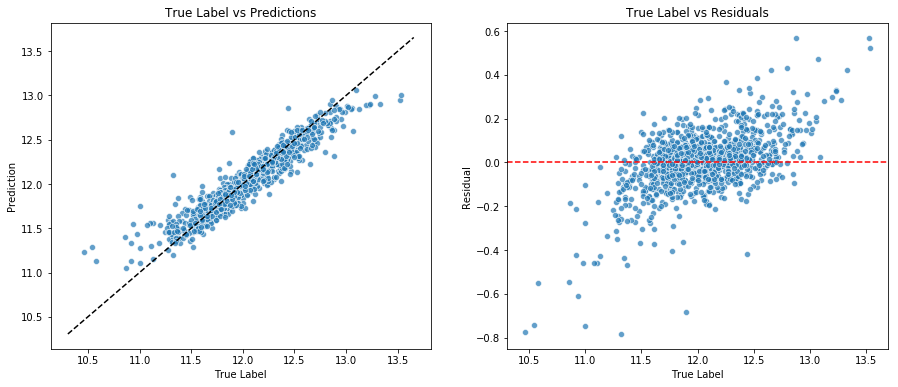

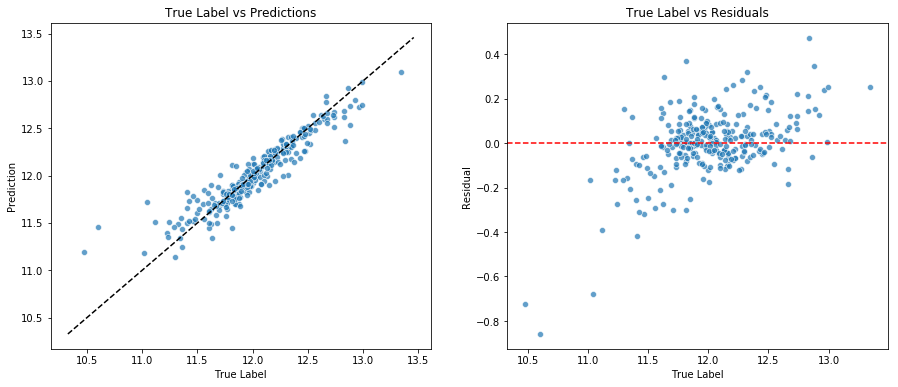

In [83]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, forest_oof)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(forest_oof)), 2)}')
plot_predictions(train_set, y, forest_oof)

tmp = train_set.copy()
forest_pipe.fit(tmp, y)
tmp = test_set.copy()
preds = forest_pipe.predict(tmp)
print(f'Test set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
print(f'Test set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
plot_predictions(test_set, y_test, preds)

Once again, the iterations led to a 6% improvement for RMSE and to a model 1500 dollars more accurate. While the result is worse than the previous 2 models, the tuning took also very little time (almost completely run time).

## Tuning XGBoost

The strategy here will be a little different as we want to make use of early stopping and tune the other hyperparameters. For some reasons, running the grid_search function above here on Kaggle, is resulting in an endless run. Luckily it is not the case locally and we can tune some of the hyperparameters following this method.

However, the most important hyperparameters to tune are arguably the learning rate and the number of estimators. We thus implement a simple method to make use of the early stopping rounds.

In [84]:
results[results.model_name == 'xgb']

model_name  rmse_train  rmse_test     mae_train      mae_test
7        xgb    0.016237   0.018083  16189.237392  15644.938851

In [85]:
def xgb_train(train, target, pipe, kfolds):

    oof = np.zeros(len(train))
    pd.options.mode.chained_assignment = None 
    
    feat_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = train.iloc[trn_idx].copy()
        val_data = train.iloc[val_idx].copy()
        
        trn_target = target.iloc[trn_idx]
        val_target = target.iloc[val_idx]
        
        trn_data = pipe.fit_transform(trn_data, trn_target)
        val_data = pipe.transform(val_data)
    
        clf = xgb.XGBRegressor(n_estimators=10000, objective='reg:squarederror',
                               max_depth=3, colsample_bytree=0.5, subsample=0.5,
                               reg_alpha=0.4, reg_lambda=0.6,
                               learning_rate=0.01, n_jobs=-1, random_state=31).fit(
            trn_data, trn_target,
            eval_set=[(val_data, val_target)], 
            eval_metric='rmse', early_stopping_rounds=200, verbose=2000)
        
        oof[val_idx] = clf.predict(pipe.transform(train.iloc[val_idx]),
                                   ntree_limit=clf.best_iteration)
        
        fold_df = pd.DataFrame()
        fold_df["feat"] = trn_data.columns
        fold_df["score"] = clf.feature_importances_     
        fold_df['fold'] = fold_ + 1
        feat_df = pd.concat([feat_df, fold_df], axis=0)
       

    feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
    feat_df['abs_sco'] = (abs(feat_df['mean']))
    feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
    del feat_df['abs_sco']

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    pd.options.mode.chained_assignment = 'warn'
    
    return oof, feat_df

In [86]:
numeric_xgb = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(bedroom=False, 
                                               lot=False))])


cat_xgb = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_xgb = dfp.FeatureUnion_df(transformer_list=[('cat', cat_xgb),
                                                 ('num', numeric_xgb)])

xgb_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_xgb),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(xgb=True))])

In [87]:
tmp = train_set.copy()

oof_xgb, f_i = xgb_train(tmp, y, xgb_pipe, folds)

f_i

fold n°0
[0]	validation_0-rmse:11.3983
Will train until validation_0-rmse hasn't improved in 200 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2000]	validation_0-rmse:0.12975
Stopping. Best iteration:
[2791]	validation_0-rmse:0.128473

fold n°1
[0]	validation_0-rmse:11.4422
Will train until validation_0-rmse hasn't improved in 200 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2000]	validation_0-rmse:0.12777
[4000]	validation_0-rmse:0.124689
Stopping. Best iteration:
[3988]	validation_0-rmse:0.124681

fold n°2
[0]	validation_0-rmse:11.4132
Will train until validation_0-rmse hasn't improved in 200 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[1040]	validation_0-rmse:0.112325

fold n°3
[0]	validation_0-rmse:11.4184
Will train until validation_0-rmse hasn't improved in 200 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[1693]	validation_0-rmse:0.113101

fold n°4
[0]	validation_0-rmse:11.4176
Will train until validation_0-rmse hasn't improved in 200 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2000]	validation_0-rmse:0.114826
Stopping. Best iteration:
[2021]	validation_0-rmse:0.114735

CV score: 0.11887 


mean       std
feat                                  
OverallQual         0.135794  0.010028
KitchenQual         0.072979  0.012236
GrLivArea           0.071382  0.007811
total_bath          0.067101  0.006452
service_area        0.064675  0.010547
Neighborhood        0.061331  0.005926
ExterQual           0.056205  0.006257
Fireplaces          0.054507  0.008905
CentralAir_Y        0.054118  0.009709
GarageCars          0.049334  0.010933
MSSubClass          0.027837  0.005932
BsmtQual            0.020304  0.008979
OverallCond         0.017383  0.003450
MisGarage           0.016158  0.004653
YearRemodAdd        0.014943  0.003216
LotArea             0.012809  0.001697
1stFlrSF            0.011008  0.000940
PavedDrive_Y        0.010255  0.004111
HeatingQC           0.010005  0.001859
OpenPorchSF         0.008709  0.002056
MSZoning_RM         0.008213  0.002445
TotRmsAbvGrd        0.007788  0.001601
BsmtUnfSF           0.007394  0.000513
YearBuilt           0.007230  0.001116
ScreenPorch         0.006407  0.001038
GarageYrBlt         0.006370  0.000626
2ndFlrSF            0.006060  0.000908
PavedDrive_P        0.005934  0.001985
GarageType_Detchd   0.005922  0.001863
WoodDeckSF          0.005807  0.000673
BldgType_Duplex     0.005774  0.001558
MisBsm              0.005550  0.002985
LotShape            0.005362  0.000988
sf_per_room         0.005280  0.000452
LotConfig_CulDSac   0.005087  0.001012
GarageFinish_Unf    0.005062  0.001160
Alley               0.004842  0.001685
BedroomAbvGr        0.004740  0.000605
HouseStyle_1Story   0.004682  0.001336
BldgType_TwnhsE     0.004653  0.000653
HouseStyle_SFoyer   0.004492  0.001721
LotConfig_Inside    0.004398  0.000982
EnclosedPorch       0.004364  0.000334
LotFrontage         0.004341  0.000765
MasVnrArea          0.004237  0.000471
GarageFinish_RFn    0.003924  0.000705
HouseStyle_2Story   0.003860  0.001056
MasVnrType_None     0.003513  0.000495
LandContour         0.003392  0.001028
3SsnPorch           0.003116  0.000839
MasVnrType_Stone    0.003104  0.000349
GarageType_BuiltIn  0.002264  0.000359

Train set RMSE: 0.1189
Train set MAE: 15163.0


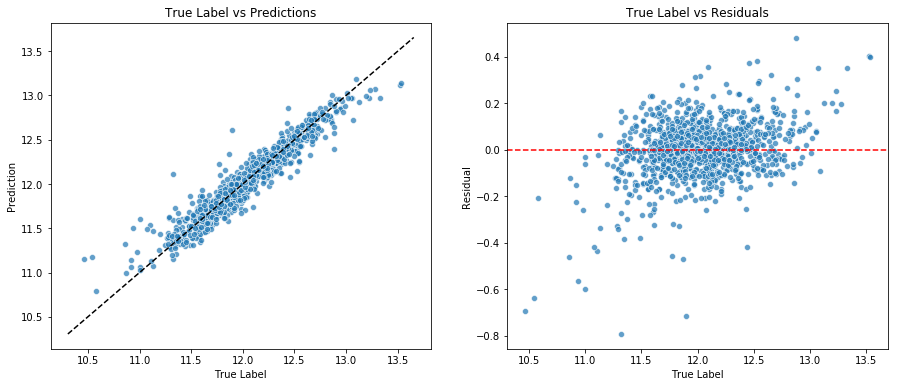

In [88]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, oof_xgb)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(oof_xgb)), 2)}')
plot_predictions(train_set, y, oof_xgb)

## Tune LightGBM

Very similarly to the previous case, we tune some hyperparameters locally and display only the latest phase

In [89]:
results[results.model_name == 'lgb']

model_name  rmse_train  rmse_test     mae_train     mae_test
8        lgb    0.017491   0.021254  16829.131771  17046.29084

In [90]:
def lgb_train(train, target, pipe, kfolds):

    oof = np.zeros(len(train))
    pd.options.mode.chained_assignment = None 
    
    feat_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = train.iloc[trn_idx].copy()
        val_data = train.iloc[val_idx].copy()
        
        trn_target = target.iloc[trn_idx]
        val_target = target.iloc[val_idx]
        
        trn_data = pipe.fit_transform(trn_data, trn_target)
        val_data = pipe.transform(val_data)
    
        clf = lgb.LGBMRegressor(n_estimators=20000, learning_rate=0.01,
                                num_leaves=4, max_depth=3,
                                subsample=0.8, colsample_bytree=0.5).fit(
            trn_data, trn_target,
            eval_set=[(val_data, val_target)], 
            eval_metric='rmse', early_stopping_rounds=200, verbose=1000)
        
        oof[val_idx] = clf.predict(pipe.transform(train.iloc[val_idx]),
                                   ntree_limit=clf.best_iteration_)
        
        fold_df = pd.DataFrame()
        fold_df["feat"] = trn_data.columns
        fold_df["score"] = clf.feature_importances_    
        fold_df['fold'] = fold_ + 1
        feat_df = pd.concat([feat_df, fold_df], axis=0)
       

    feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
    feat_df['abs_sco'] = (abs(feat_df['mean']))
    feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
    del feat_df['abs_sco']

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    pd.options.mode.chained_assignment = 'warn'
    
    return oof, feat_df

In [91]:
numeric_lgb = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(bedroom=False,
                                               SF_room=False,
                                               lot=False))])


cat_lgb = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_lgb = dfp.FeatureUnion_df(transformer_list=[('cat', cat_lgb),
                                                 ('num', numeric_lgb)])

lgb_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lgb),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(lgb=True))])

In [92]:
tmp = train_set.copy()

oof_lgb, f_i = lgb_train(tmp, y, lgb_pipe, folds)

f_i

fold n°0
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l2: 0.0177365	valid_0's rmse: 0.133179
[2000]	valid_0's l2: 0.0167452	valid_0's rmse: 0.129403
[3000]	valid_0's l2: 0.0161658	valid_0's rmse: 0.127145
[4000]	valid_0's l2: 0.0159022	valid_0's rmse: 0.126104
[5000]	valid_0's l2: 0.0158143	valid_0's rmse: 0.125755
Early stopping, best iteration is:
[5499]	valid_0's l2: 0.0157642	valid_0's rmse: 0.125556
fold n°1
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l2: 0.0174706	valid_0's rmse: 0.132177
[2000]	valid_0's l2: 0.0163468	valid_0's rmse: 0.127854
[3000]	valid_0's l2: 0.01606	valid_0's rmse: 0.126728
[4000]	valid_0's l2: 0.0159467	valid_0's rmse: 0.12628
Early stopping, best iteration is:
[4204]	valid_0's l2: 0.0158812	valid_0's rmse: 0.126021
fold n°2
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l2: 0.0134275	valid_0's rmse: 0.115877
Early stopping, best iteration is:
[1077]	val

mean         std
feat                                 
service_area        740.8  553.812875
LotArea             665.4  526.951895
1stFlrSF            646.8  589.969236
BsmtUnfSF           631.6  538.514902
GrLivArea           620.2  349.597912
OverallCond         418.2  174.964854
GarageYrBlt         391.6  329.095427
YearBuilt           384.6  293.884841
Neighborhood        354.0  259.986538
OverallQual         303.6  210.422907
2ndFlrSF            292.8  214.561646
total_bath          252.2  170.521846
YearRemodAdd        237.6  207.598892
OpenPorchSF         237.2  235.872211
WoodDeckSF          201.8  191.167989
MasVnrArea          164.8  175.310296
ScreenPorch         136.0   71.599581
HeatingQC           123.0  113.659579
MSSubClass          114.4   75.533436
Fireplaces          105.8   37.592552
EnclosedPorch       104.0  128.128841
GarageCars           97.6   80.568604
KitchenQual          94.4   66.979848
CentralAir_Y         92.2   69.926390
TotRmsAbvGrd         86.4   68.193108
LotConfig_CulDSac    74.8   34.600578
PavedDrive_Y         67.8   23.209912
BsmtQual             59.8   65.739638
MSZoning_RM          55.4   76.271227
LotConfig_Inside     47.0   37.755794
GarageFinish_Unf     45.8   54.988181
BedroomAbvGr         39.6   62.111191
LotShape             27.6   28.236501
ExterQual            27.4   33.095317
GarageType_Detchd    26.4   34.896991
BldgType_Duplex      26.0   39.242834
LandContour          25.6   36.773632
GarageFinish_RFn     19.4   18.716303
MasVnrType_None      18.6   26.959228
MasVnrType_Stone     17.2   22.851696
MisGarage            15.0    4.062019
Alley                 1.6    3.577709
BldgType_TwnhsE       1.4    3.130495
PavedDrive_P          0.0    0.000000
GarageType_BuiltIn    0.0    0.000000
ExterCond             0.0    0.000000
BsmtCond              0.0    0.000000
3SsnPorch             0.0    0.000000
BsmtExposure          0.0    0.000000

Train set RMSE: 0.1208
Train set MAE: 15229.67


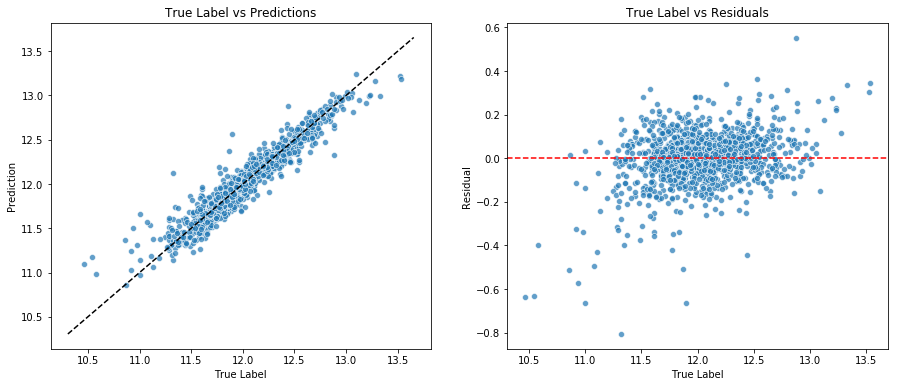

In [93]:
print(f'Train set RMSE: {round(np.sqrt(mean_squared_error(y, oof_lgb)), 4)}')
print(f'Train set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(oof_lgb)), 2)}')
plot_predictions(train_set, y, oof_lgb)

# Error Analysis, interpretation, and model improvement

We got our first improvements, our models are already better than, for example, a simple regression using the size of the house in combination with the neighborhood.

It is a good moment to stop and think about what is our model saying and what is missing.

***This section is made out of intuition, I am genuinely unaware if what follows makes sense mathematically. Any feedback on this part will be particularly appreciated***

First, let's put our prediction together with the data that led to them.

In [94]:
err_an  = train_set.copy()

err_an['lasso_oof'] = lasso_oof
err_an['ridge_oof'] = ridge_oof
err_an['forest_oof'] = forest_oof
err_an['xgb_oof'] = oof_xgb
err_an['lgb_oof'] = oof_lgb
err_an['target'] = y

err_an.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1231  1233          90       RL         70.0     9842   Pave   NaN      Reg   
1456  1459          20       RL         68.0     9717   Pave   NaN      Reg   
242    243          50       RM         63.0     5000   Pave   NaN      Reg   
93      94         190  C (all)         60.0     7200   Pave   NaN      Reg   
1268  1270          50       RL         78.0    11344   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1231         Lvl    AllPub       FR2       Gtl        NAmes       Norm   
1456         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
242          Lvl    AllPub    Corner       Gtl      OldTown       Norm   
93           Lvl    AllPub    Corner       Gtl      OldTown       Norm   
1268         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1231       Norm   Duplex     1Story            4            5       1962   
1456       Norm     1Fam     1Story            5            6       1950   
242        Norm     1Fam     1.5Fin            5            4       1900   
93         Norm   2fmCon     2.5Unf            6            6       1910   
1268       Norm     1Fam     1.5Fin            5            5       1958   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1231          1962     Gable  CompShg     HdBoard     HdBoard       None   
1456          1996       Hip  CompShg     MetalSd     MetalSd       None   
242           1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
93            1998       Hip  CompShg     MetalSd     MetalSd       None   
1268          1958     Gable  CompShg     MetalSd     MetalSd    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1231         0.0        TA        TA       Slab      NaN      NaN   
1456         0.0        TA        TA     CBlock       TA       TA   
242          0.0        TA        TA     BrkTil       TA       TA   
93           0.0        TA        TA     BrkTil       TA       Fa   
1268       180.0        TA        TA     CBlock       TA       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1231          NaN          NaN           0          NaN           0   
1456           Mn          GLQ          49          Rec        1029   
242            No          Unf           0          Unf           0   
93             Mn          Rec        1046          Unf           0   
1268           No          BLQ         460          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1231          0            0    GasA        TA          Y      SBrkr   
1456          0         1078    GasA        Gd          Y      FuseA   
242         540          540    GasA        Gd          N      FuseA   
93          168         1214    GasW        Ex          N      SBrkr   
1268        414          874    GasW        TA          Y      FuseA   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1231      1224         0             0       1224             0             0   
1456      1078         0             0       1078             1             0   
242        889       551             0       1440             0             0   
93        1260      1031             0       2291             0             1   
1268       874       650             0       1524             0             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1231         2         0             2             2          TA   
1456         1         0             2             1          Gd   
242          1         0             3             1          TA   
93           2         0             4             2          TA   
1268         1         1             3             1          TA   

   

We can see how all the predictions are very correlated to one another (and with the target, this is good)

target        1.000000
ridge_oof     0.956344
lasso_oof     0.956183
xgb_oof       0.955038
lgb_oof       0.953418
forest_oof    0.948226
Name: target, dtype: float64

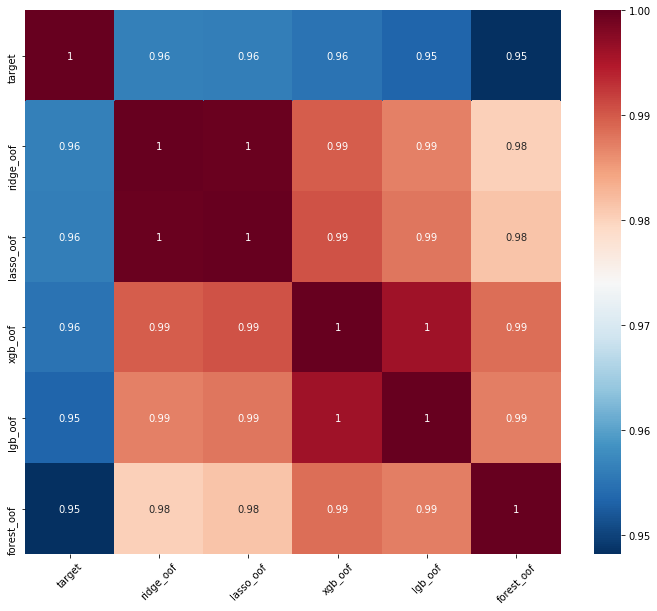

In [95]:
exp.plot_correlations(err_an[[col for col in err_an.columns if '_oof' in col]+['target']], 
                      target='target', annot=True)

If we compute the residuals and plot them, the pattern looks even more evident.

            lasso_oof  ridge_oof  forest_oof   xgb_oof   lgb_oof  lasso_res  \
lasso_oof    1.000000   0.999656    0.981546  0.990628  0.987936   0.013508   
ridge_oof    0.999656   1.000000    0.980228  0.989843  0.987201   0.015176   
forest_oof   0.981546   0.980228    1.000000  0.988508  0.987443   0.046349   
xgb_oof      0.990628   0.989843    0.988508  1.000000  0.996088   0.040077   
lgb_oof      0.987936   0.987201    0.987443  0.996088  1.000000   0.043297   
lasso_res    0.013508   0.015176    0.046349  0.040077  0.043297   1.000000   
ridge_res    0.000062  -0.000514    0.036422  0.028258  0.031364   0.996234   
forest_res   0.338323   0.342254    0.265968  0.316660  0.314526   0.806682   
xgb_res      0.080560   0.083588    0.060472  0.046984  0.053931   0.902735   
lgb_res      0.072498   0.075335    0.047676  0.043154  0.025527   0.877254   
target       0.956183   0.956344    0.948226  0.955038  0.953418   0.305659   

            ridge_res  forest_res   xgb_res   lgb_r

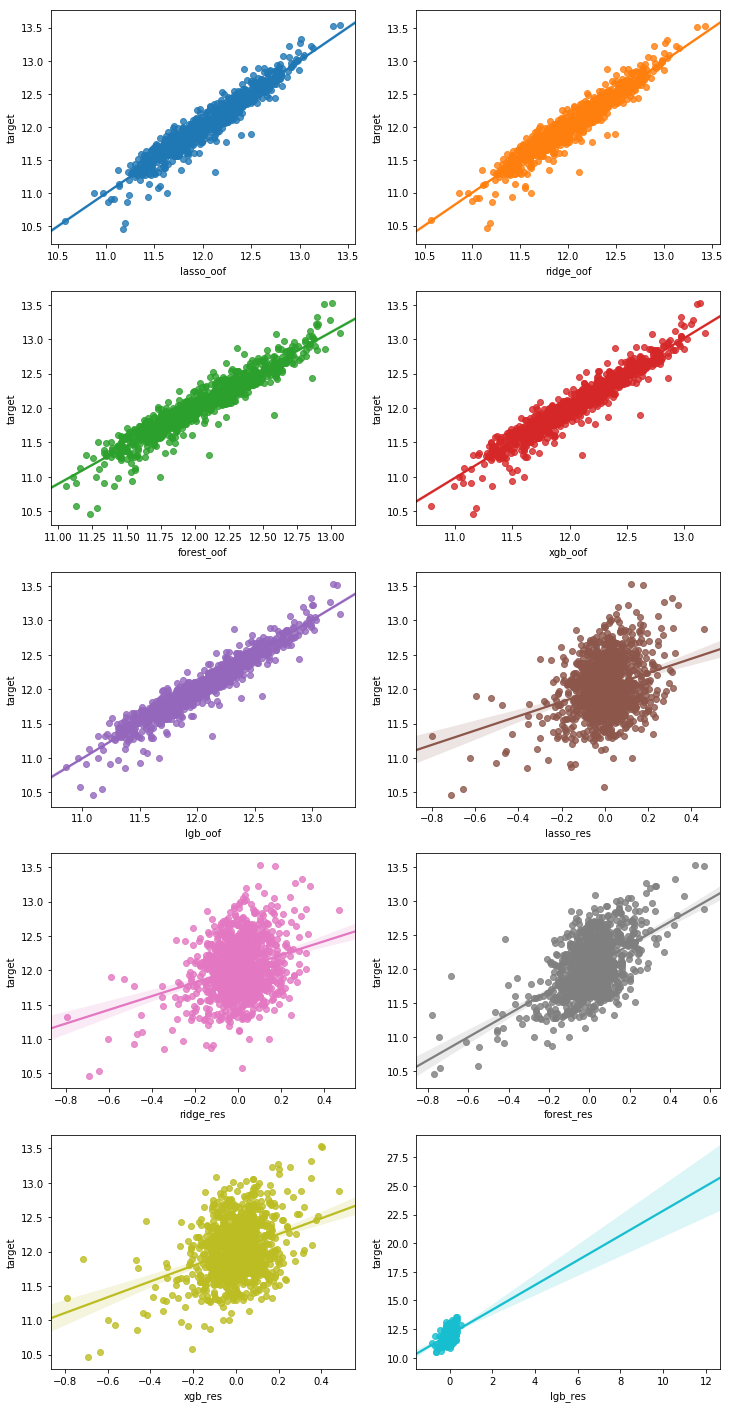

In [96]:
oof_cols = [col for col in err_an.columns if '_oof' in col]

for col in oof_cols:
    name = col.replace('_oof', '_res')
    err_an[name] = err_an['target'] - err_an[col]
    
exp.corr_target(err_an, 'target', 
            [col for col in err_an.columns if '_oof' in col]+
                [col for col in err_an.columns if '_res' in col])

Looking at the residual plots, it appears evident that all the models we trained so far are underestimating the price of low costs houses and overestimating the more expensive ones. This could be because we used some target encoding or simply that we are overestimating, for example, the importance of the house size.

Since the predictions do not change much from model to model, we can simply focus on one of them. For example, let's focus on LightGBM.

We can try to see if there are interesting relations between the residuals and the original features.

lgb_res          1.000000
xgb_res          0.961143
lasso_res        0.877254
ridge_res        0.868569
forest_res       0.864627
target           0.325891
BsmtFinSF1       0.100632
YrSold          -0.080069
OverallCond      0.076944
ridge_oof        0.075335
lasso_oof        0.072498
Id              -0.066717
LowQualFinSF    -0.064402
TotalBsmtSF      0.061472
LotArea          0.059632
GrLivArea        0.058686
ScreenPorch      0.052852
1stFlrSF         0.048997
WoodDeckSF       0.048407
OverallQual      0.047939
forest_oof       0.047676
PoolArea         0.044772
YearBuilt        0.044479
Fireplaces       0.044136
xgb_oof          0.043154
KitchenAbvGr    -0.041202
MasVnrArea       0.040290
GarageCars       0.039057
YearRemodAdd     0.037888
2ndFlrSF         0.033847
TotRmsAbvGrd     0.032270
BsmtUnfSF       -0.032132
BsmtFullBath     0.029115
HalfBath         0.028828
lgb_oof          0.025527
LotFrontage      0.024109
BsmtFinSF2      -0.022572
MSSubClass       0.017471
FullBath    

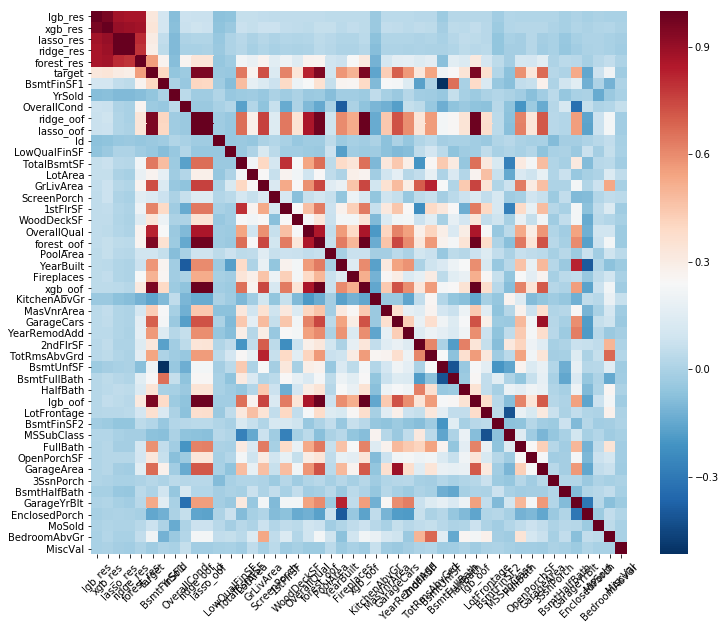

In [97]:
exp.plot_correlations(err_an, target='lgb_res')

Which shows little to nothing. However, for categorical features, we can start focusing on the feature that was used both to stratify our folds (and test set) and then to be target encoded: Neighborhood.

Neighborhood  count_res  mean_res   max_res   min_res  median_res  \
0       Blmngtn         14 -0.003755  0.252137 -0.258945    0.017240   
1       Blueste          2 -0.011675 -0.005291 -0.018059   -0.011675   
2        BrDale         13 -0.004108  0.128965 -0.135943   -0.004242   
3       BrkSide         46  0.032334  0.342120 -0.513648    0.054220   
4       ClearCr         22  0.022957  0.294185 -0.507721    0.040667   
5       CollgCr        120  0.000308  0.266519 -0.172275    0.001294   
6       Crawfor         41  0.032758  0.313422 -0.192891    0.036425   
7       Edwards         78 -0.001339  0.363077 -0.662838    0.012647   
8       Gilbert         63  0.001887  0.189422 -0.167342    0.007406   
9        IDOTRR         30 -0.026341  0.175755 -0.635507    0.006323   
10      MeadowV         14 -0.007896  0.128425 -0.137026   -0.025705   
11      Mitchel         39  0.005704  0.191086 -0.396860    0.022270   
12        NAmes        180  0.004251  0.282753 -0.422851    0.010714   
13      NPkVill          7 -0.009874  0.040754 -0.096978    0.003550   
14       NWAmes         58 -0.034427  0.152367 -0.805560   -0.015454   
15      NoRidge         33  0.004493  0.347416 -0.251182   -0.002113   
16      NridgHt         62 -0.001064  0.334790 -0.443231   -0.009582   
17      OldTown         90 -0.025903  0.318573 -0.630123   -0.014625   
18        SWISU         20 -0.000824  0.280894 -0.158118   -0.021571   
19       Sawyer         59  0.004440  0.207664 -0.345772    0.017337   
20      SawyerW         47 -0.010375  0.183271 -0.311013   -0.014391   
21      Somerst         69  0.005864  0.140586 -0.663794    0.021190   
22      StoneBr         20  0.074706  0.553204 -0.133618    0.040614   
23       Timber         30 -0.034430  0.180074 -0.340637   -0.052296   
24      Veenker          9  0.036840  0.135697 -0.093377    0.054839   

     std_res  mean_target  max_target  min_target  median_target  std_target  
0   0.138034    12.179361   12.485831   11.982279      12.133146    0.159205  
1   0.009028    11.826543   11.925042   11.728045      11.826543    0.139298  
2   0.075754    11.560918   11.736077   11.355113      11.571204    0.132869  
3   0.158921    11.676040   12.317171   10.579005      11.706027    0.372509  
4   0.175790    12.275824   12.700772   11.775297      12.291739    0.234329  
5   0.070654    12.172197   12.858322   11.608245      12.214770    0.248028  
6   0.115191    12.229254   12.850557   11.411457      12.289959    0.317566  
7   0.151960    11.684095   12.524421   10.976799      11.686887    0.289471  
8   0.074671    12.161274   12.841328   11.856522      12.106258    0.170260  
9   0.198898    11.505145   12.040614   10.460271      11.582903    0.352477  
10  0.071305    11.488241   11.927687   11.289794      11.401865    0.208132  
11  0.108130    11.917029   12.509878   11.344519      11.870607    0.248889  
12  0.104114    11.871310   12.751303   11.379406      11.856522    0.213576  
13  0.050158    11.859168   11.951187   11.755879      11.891369    0.075371  
14  0.131025    12.125646   12.610874   11.320566      12.106258    0.201525  
15  0.129636    12.662495   13.534474   12.154785      12.577640    0.286628  
16  0.115951    12.629955   13.323929   11.944714      12.669810    0.306945  
17  0.160488    11.708541   13.071072   10.542733      11.680545    0.349236  
18  0.137307    11.785810   12.149508   11.002117      11.825352    0.255277  
19  0.099752    11.826258   12.154785   11.289794      11.813037    0.164661  
20  0.092994    12.081378   12.665398   11.314487      12.100162    0.298357  
21  0.109731    12.286088   12.955130   11.878631      12.283038    0.247530  
22  0.161236    12.607582   13.229570   12.043560      12.529955    0.370462  
23  0.104833    12.335184   12.843974   11.831386      12.307519    0.271700  
24  0.071364    12.372762   12.861001   11.998439      12.411056    0.312765

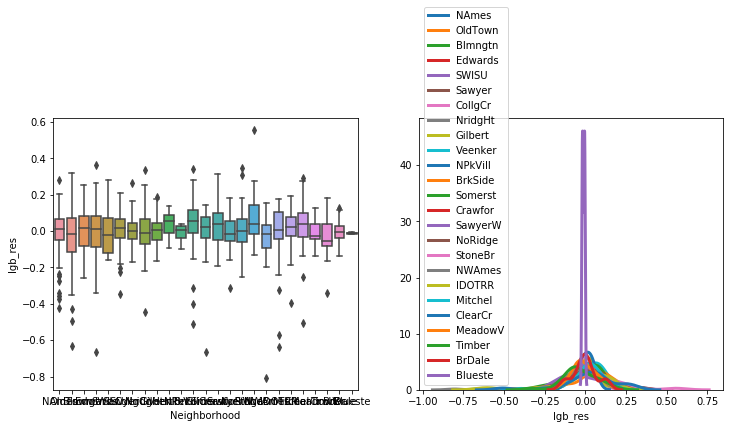

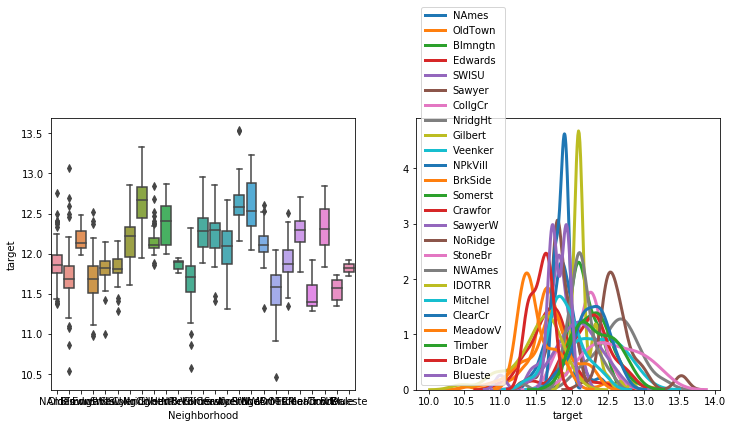

In [98]:
err = exp.segm_target(err_an, 'Neighborhood', 'lgb_res')
tar = exp.segm_target(err_an, 'Neighborhood', 'target')

tot = pd.merge(err.reset_index(), tar.reset_index(), on='Neighborhood', suffixes=('_res', '_target'))

del tot['count_target']

tot

In [99]:
tot.corr()

count_res  mean_res   max_res   min_res  median_res   std_res  \
count_res       1.000000 -0.111255  0.278148 -0.403828   -0.025091  0.092844   
mean_res       -0.111255  1.000000  0.557643  0.321883    0.800116  0.138772   
max_res         0.278148  0.557643  1.000000 -0.191840    0.331615  0.673882   
min_res        -0.403828  0.321883 -0.191840  1.000000   -0.016349 -0.649497   
median_res     -0.025091  0.800116  0.331615 -0.016349    1.000000  0.255143   
std_res         0.092844  0.138772  0.673882 -0.649497    0.255143  1.000000   
mean_target    -0.024756  0.382607  0.372043  0.111581    0.166646  0.034464   
max_target      0.352306  0.292750  0.604152 -0.197498    0.138346  0.284869   
min_target     -0.206834  0.297795 -0.038471  0.461694    0.070905 -0.411185   
median_target  -0.020592  0.382542  0.356032  0.099500    0.193398  0.042494   
std_target      0.134504  0.346920  0.658299 -0.348107    0.263323  0.640332   

               mean_target  max_target  min_target  median_target  std_target  
count_res        -0.024756    0.352306   -0.206834      -0.020592    0.134504  
mean_res          0.382607    0.292750    0.297795       0.382542    0.346920  
max_res           0.372043    0.604152   -0.038471       0.356032    0.658299  
min_res           0.111581   -0.197498    0.461694       0.099500   -0.348107  
median_res        0.166646    0.138346    0.070905       0.193398    0.263323  
std_res           0.034464    0.284869   -0.411185       0.042494    0.640332  
mean_target       1.000000    0.823236    0.792766       0.991543    0.222194  
max_target        0.823236    1.000000    0.430760       0.804493    0.531317  
min_target        0.792766    0.430760    1.000000       0.760294   -0.316768  
median_target     0.991543    0.804493    0.760294       1.000000    0.246387  
std_target        0.222194    0.531317   -0.316768       0.246387    1.000000

A few noticeable things are:

* the more houses from a neighborhood, the smaller the error on average. This is also the pattern with the price, so we have to be mindful of that (neighborhood with more examples tend to have lower costs on average).
* We can confirm that neighborhood for which we have houses with higher average cost also get a higher error (not in the absolute sense).

This makes me consider if it would be a good idea to not use the target encoding variables and see if that pattern in the error disappears.

Another possible test is to see if some variables we did not include, for example

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


count      mean       max       min    median       std
Exterior1st                                                         
AsbShng         12 -0.077154  0.175755 -0.353562 -0.070225  0.137097
AsphShn          1 -0.057223 -0.057223 -0.057223 -0.057223       NaN
BrkComm          2 -0.275193  0.112451 -0.662838 -0.275193  0.548212
BrkFace         38  0.074459  0.342120 -0.188186  0.083093  0.118547
CBlock           1 -0.012961 -0.012961 -0.012961 -0.012961       NaN
CemntBd         44  0.006324  0.276128 -0.158424 -0.004778  0.082507
HdBoard        176 -0.011524  0.347416 -0.345772 -0.013229  0.094851
ImStucc          1 -0.057845 -0.057845 -0.057845 -0.057845       NaN
MetalSd        182  0.012628  0.553204 -0.330023  0.010039  0.111818
Plywood         83  0.000122  0.363077 -0.805560  0.016353  0.145964
Stucco          21 -0.006912  0.191492 -0.339245  0.059442  0.142485
VinylSd        416  0.000118  0.334790 -0.663794  0.007575  0.116473
Wd Sdng        167 -0.010303  0.306011 -0.635507  0.004152  0.142003
WdShing         22  0.000803  0.282451 -0.157947 -0.013864  0.103816

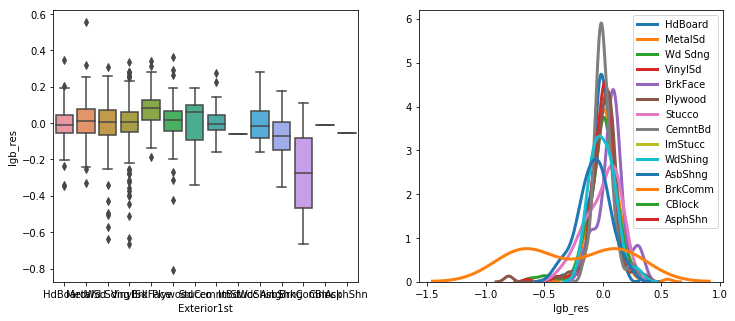

In [100]:
exp.segm_target(err_an, 'Exterior1st', 'lgb_res')

This shows how the `MetalSd` exterior leads to a particularly different pattern in the distribution of the error. A direct inspection of these houses shows the following

In [101]:
err_an[err_an.Exterior1st == 'MetalSd'].describe() - err_an[err_an.Exterior1st != 'MetalSd'].describe()

Id  MSSubClass  LotFrontage        LotArea  OverallQual  \
count -802.000000 -802.000000  -641.000000    -802.000000  -802.000000   
mean    33.059915   12.026936    -9.421806   -2182.179152    -0.635889   
std     -5.602309   10.174723    -5.901617   -5417.188018    -0.111310   
min      1.000000    0.000000     3.000000    -177.000000     2.000000   
25%     63.500000    0.000000    -9.000000   -1665.250000     0.000000   
50%     63.500000    0.000000   -10.000000   -1197.500000    -1.000000   
75%     11.000000   20.000000   -10.000000   -1419.500000    -1.000000   
max     -1.000000    0.000000  -175.000000 -129527.000000    -1.000000   

       OverallCond   YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
count  -802.000000 -802.000000   -802.000000 -794.000000 -802.000000   
mean      0.308329  -17.211918     -9.124777  -18.979013  -67.645604   
std      -0.032657   -0.449653      1.996339    1.666882  -67.397963   
min       1.000000   -3.000000      0.000000    0.000000    0.000000   
25%       0.000000  -18.750000    -15.750000    0.000000    0.000000   
50%       1.000000  -20.000000    -19.000000    0.000000  -26.000000   
75%       1.000000  -27.000000     -4.250000  -63.750000 -141.250000   
max       0.000000   -1.000000     -1.000000 -471.000000 -492.000000   

       BsmtFinSF2   BsmtUnfSF  TotalBsmtSF     1stFlrSF    2ndFlrSF  \
count -802.000000 -802.000000  -802.000000  -802.000000 -802.000000   
mean   -14.069072  -51.306319  -133.020995  -152.805101  -21.133309   
std    -37.909031 -113.068597  -104.254079   -93.426591  -54.785960   
min      0.000000    0.000000     0.000000   186.000000    0.000000   
25%      0.000000   58.000000   -79.000000   -75.500000    0.000000   
50%      0.000000   34.500000  -110.500000  -126.000000    0.000000   
75%      0.000000  -78.750000  -248.500000  -237.500000  -79.750000   
max   -445.000000 -284.000000 -1097.000000 -1115.000000 -454.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath    FullBath  \
count   -802.000000  -802.000000   -802.000000   -802.000000 -802.000000   
mean      10.388412  -163.549998     -0.044470     -0.031471   -0.223521   
std       33.079467   -79.585899     -0.008811     -0.076010   -0.021473   
min        0.000000   186.000000      0.000000      0.000000    1.000000   
25%        0.000000   -72.250000      0.000000      0.000000    0.000000   
50%        0.000000  -185.500000      0.000000      0.000000   -1.000000   
75%        0.000000  -233.250000      0.000000      0.000000    0.000000   
max      -44.000000 -1390.000000     -1.000000     -1.000000    0.000000   

         HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
count -802.000000   -802.000000   -802.000000   -802.000000 -802.000000   
mean    -0.071752     -0.111040      0.031191     -0.458546   -0.215324   
std      0.002602      0.019058      0.068611     -0.014639   -0.035610   
min      0.000000      1.000000      1.000000      1.000000    0.000000   
25%      0.000000      0.000000      0.000000     -1.000000    0.000000   
50%      0.000000      0.000000      0.000000      0.000000   -1.000000   
75%      0.000000      0.000000      0.000000     -1.000000    0.000000   
max      0.000000      0.000000      0.000000      0.000000   -1.000000   

       GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
count  -763.000000 -802.000000 -802.000000 -802.000000  -802.000000   
mean    -11.979011   -0.303449  -72.777886  -34.382516   -14.751597   
std       0.919317   -0.018979   -7.821897  -25.002583   -10.243068   
min      -8.000000    0.000000    0.000000    0.000000     0.000000   
25%     -14.000000    0.000000  -70.500000    0.000000     0.000000   
50%     -19.000000    0.000000  -51.500000    0.000000   -28.000000   
75%     -10.000000    0.000000  -54.500000  -49.250000   -21.000000   
max      -1.000000    0.000000 -142.000000 -362.000000  -262.000000   

       EnclosedPorch   3SsnPorch  ScreenPorch    PoolArea 

In other words, houses with that particular exterior

* Are less likely to have land in front of them
* Are lower in quality, in particular they never hit the perfect score. This could be interpreted as a bias in the data collection
* Were built less recently, which makes perfect sense as building techniques change with time
* Have much smaller basements and garages
* Are much smaller in general
* Are less likely to have a fireplace
* Cost less in general

We could then consider to include this feature as well and see how the model reacts.

Another approach would be to explore the entries with the biggest errors. For example

In [102]:
def high_low_errors(data, *, res_list=None, n_samples=50,
                    target=None, pred_list=None, mean=False, 
                    abs_err=True, common=False):
    
    df = data.copy()
    if pred_list:
        res_list = []
        for col in pred_list:
            name = col + '_res'
            res_list.append(name)
            df[name] = df[target] - df[col]
    
    errors = {}
    
    if mean:
        df['mean_res'] = df[res_list].mean(axis=1)
        res_list += ['mean_res']

    for col in res_list:
        if abs_err:
            if col == 'abs_err':
                name = 'abs_err'
            else:
                name = 'abs_' + col
            df[name] = abs(df[col])
        else:
            name = col
        
        high_err = df.sort_values(name, ascending=False).head(n_samples)
        low_err = df.sort_values(name, ascending=False).tail(n_samples)
        
        try:
            errors[name] = high_err.describe(include='all').drop(index=['top', 'count', 'freq']).fillna(0) - \
                        low_err.describe(include='all').drop(index=['top', 'count', 'freq']).fillna(0)
        except KeyError:
            errors[name] = high_err.describe().fillna(0) - low_err.describe().fillna(0)
        
    return errors

In [103]:
h_v_l = high_low_errors(err_an, res_list=[col for col in err_an.columns if '_res' in col], mean=True)

h_v_l['abs_mean_res']

Id  MSSubClass  MSZoning  LotFrontage       LotArea  Street  \
unique    0.000000    0.000000         0     0.000000      0.000000       0   
mean     97.640000    3.700000         0     4.951220     14.480000       0   
std     -16.772012   -0.749065         0     4.125358 -12491.635447       0   
min       3.000000    0.000000         0    24.000000   2653.000000       0   
25%     160.500000    0.000000         0    -1.000000     40.250000       0   
50%     117.500000   30.000000         0    -2.000000   1329.500000       0   
75%     -15.750000    0.000000         0     6.000000   2809.750000       0   
max      -2.000000    0.000000         0    31.000000 -93899.000000       0   

        Alley  LotShape  LandContour  Utilities  LotConfig  LandSlope  \
unique      0         0            1          1         -2          0   
mean        0         0            0          0          0          0   
std         0         0            0          0          0          0   
min         0         0            0          0          0          0   
25%         0         0            0          0          0          0   
50%         0         0            0          0          0          0   
75%         0         0            0          0          0          0   
max         0         0            0          0          0          0   

        Neighborhood  Condition1  Condition2  BldgType  HouseStyle  \
unique             3           1           1        -1           2   
mean               0           0           0         0           0   
std                0           0           0         0           0   
min                0           0           0         0           0   
25%                0           0           0         0           0   
50%                0           0           0         0           0   
75%                0           0           0         0           0   
max                0           0           0         0           0   

        OverallQual  OverallCond  YearBuilt  YearRemodAdd  RoofStyle  \
unique     0.000000     0.000000   0.000000      0.000000          1   
mean       0.060000     0.080000 -21.080000     -3.520000          0   
std        0.679703     0.570688   8.008223      3.055657          0   
min       -1.000000    -2.000000  12.000000      0.000000          0   
25%        0.000000     0.000000 -32.250000    -11.500000          0   
50%        0.000000     0.000000 -17.500000    -11.000000          0   
75%        0.000000     0.000000 -22.250000      1.000000          0   
max        2.000000     1.000000   2.000000      1.000000          0   

        RoofMatl  Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  ExterQual  \
unique         2            4            2           0    0.000000          2   
mean           0            0            0           0  -15.560000          0   
std            0            0            0           0  -28.588998          0   
min            0            0            0           0    0.000000          0   
25%            0            0            0           0    0.000000          0   
50%            0            0            0           0    0.000000          0   
75%            0            0            0           0  -34.000000          0   
max            0            0            0           0 -430.000000          0   

        ExterCond  Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
unique          0           0         0         0             0             0   
mean            0           0         0         0             0             0   
std             0           0         0         0             0             0   
min             0           0         0         0             0             0   
25%             0           0         0         0             0             0   
50%             0           0         0         0             0             0   
75%             0           0         0         0             0      

* Alley is a low cardinality feature, that difference might be interesting
* High errors have bigger LotFrontage but much smaller LotArea
* Low errors are built more recently
* High errors have a bigger basement but also more unfinished
* High errors are much bigger in general
* It appears we are not capturing the MiscVal
* The high are negative on average, meaning that they overestimate the price.
* Low errors are coming from more expensive houses.

## Interpreting the results

We may have to explain to the stakeholders of the project what is our model doing to make its prediction. This is a very complicated question when we step away from the simplest models (that, to be honest, are performing well enough if we compare them to the more complex ones here presented). However, some simple things might just do the job.

Let's focus on our RandomForest, we know already how off the predictions are and, if we don't want to scroll up this notebook, we can see what features are the most important.

In [104]:
imps = get_feature_importance(forest_pipe)

imps.head(9)

feat     score
28   OverallQual  0.127288
36     GrLivArea  0.101079
48  service_area  0.093164
4   Neighborhood  0.090140
5      ExterQual  0.064130
8    KitchenQual  0.052239
47    total_bath  0.050637
30     YearBuilt  0.041843
34      1stFlrSF  0.041818

/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


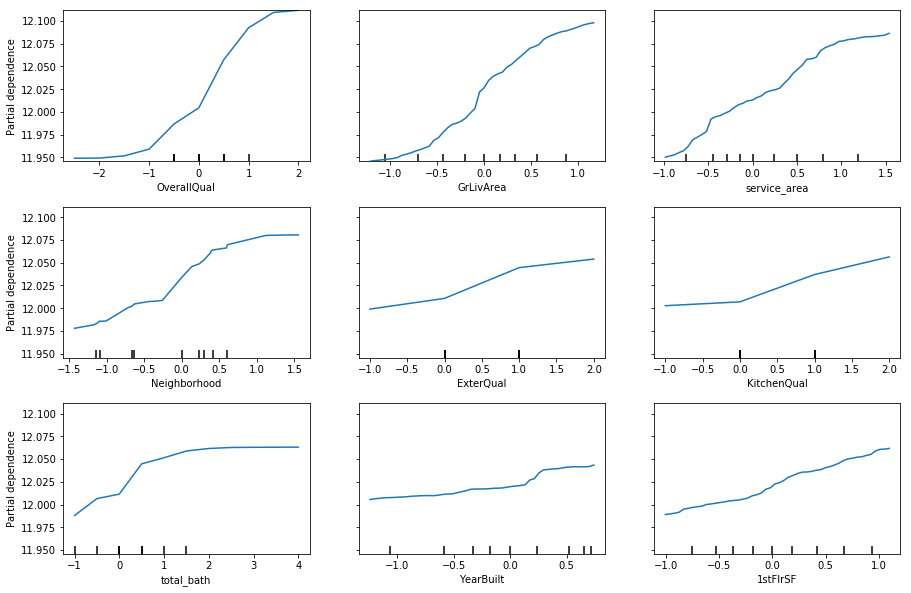

In [105]:
features = imps.head(9).feat.values
# we need the data to be tranformed, so I break the pipe in 2 parts
proc = Pipeline([('gen_cl', general_cleaner()),
                 ('proc', processing_forest),
                 ('scaler', dfp.df_scaler(method='robust')),
                 ('dropper', drop_columns(forest=True))])
tmp = proc.fit_transform(train_set.copy(), y)
ls_tm = RandomForestRegressor(n_estimators=1500, max_depth=30,
                              max_features='sqrt',
                              n_jobs=-1, random_state=32)
ls_tm.fit(tmp, y)

fig, ax = plt.subplots(3,3, figsize=(15,10))

plot_partial_dependence(ls_tm, tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

We see that around the mean (the 0 in this graphs), there is generally a big step up in price predicted. 

Or, we can combine 2 features to get different insights

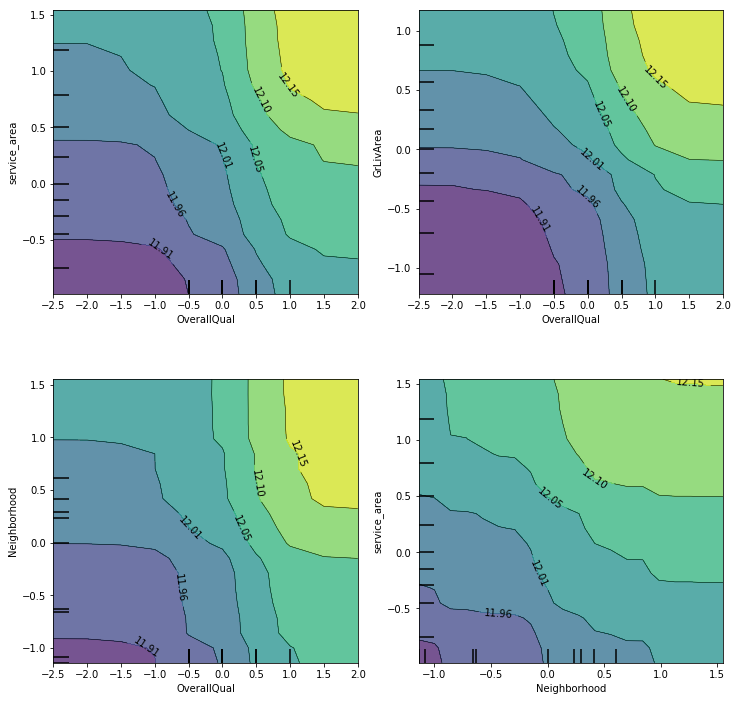

In [106]:
features = [('OverallQual', 'service_area'), ('OverallQual', 'GrLivArea'), 
            ('OverallQual', 'Neighborhood'), ('Neighborhood', 'service_area')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(ls_tm, tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

# Stacking, blending, having fun

... to be continued ....

### To be continued. Thank your reading this unfinished notebook, please feel free to ask for clarification or suggest other things I should cover in the next sections (even if most of them are already planned)